# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import pickle
import sys

"""
Add gym-hiring directory to current path. I believe this is needed
when referencing a pip "file:///" dependency.
"""
for p in ['..', '../..', '../../..', '../../../..']:
    d = os.path.abspath(p)
    if d not in sys.path:
        sys.path.insert(0,d)
        
%load_ext autoreload

In [2]:
import logging
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
sns.set(font_scale=1.2)

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# Experiment Helpers

In [4]:
from abc import ABC, abstractmethod


class Agent(ABC):
    def __init__(self, env):
        self.env = env
        
    @abstractmethod
    def select_action(self, obs, eps=None):
        pass
    
    @abstractmethod
    def add_experience(self, prev_obs, action, reward, obs, done):
        pass

    @abstractmethod
    def train(self, timestep):
        pass
    
    
class RandomAgent(Agent):
    
    def __init__(self, env):
        self.env = env
        
    def select_action(self, obs, eps=None):
        # Sample random action
        a = np.random.choice(
            np.arange(self.env.n_actions),
            p=(np.ones(self.env.n_actions)/self.env.n_actions))
        return a
    
    def add_experience(self, prev_obs, action, reward, obs, done):
        pass

    def train(self, timestep):
        pass
    
    
class FixedPolicyAgent(Agent):
    
    def __init__(self, env, pi):
        self.env = env
        self.pi = pi
        
    def select_action(self, obs, eps=None):
        a = self.pi[obs]
        return a
    
    def add_experience(self, prev_obs, action, reward, obs, done):
        pass

    def train(self, timestep):
        pass

# Loan Experiment

### Shared

##### Imports

In [5]:
%autoreload 2
    
import gym
from research.rl.env.helpers import play_n_episodes
from research.rl.env.discrete_mdp import DiscreteMDP, compute_optimal_policy

##### `MultiObjectiveDiscreteMDP` Source Code

In [60]:
import numpy as np
import pandas as pd


class MultiObjectiveDiscreteMDP(DiscreteMDP):
    
    def __init__(self, state_dims, action_dims, obs_dims,
                 max_steps_per_episode, Osaso_dtype, verbose=False, args={},
                 obj_weights=np.array([1, 0, 0]), T=None, Osaso=None,
                 Rsas=None):
        """
        Additional Parameters beyond DiscreteMDPs
        -----------------------------------------
        obj_weights : np.array<int>
            Objective preference weights (lambdas) for multi-objective a priori method.
        
        Additional Attributes beyond DiscreteMDPs
        -----------------------------------------
        n_objectives : int
            Number of reward objectives.
        Rsasl : np.ndarray (n_states, n_actions, n_states, n_objectives)
            4-dim matrix where index [s][a][s'][l] represents the reward
            component for the l'th objective transitioning from state s to
            state s' after taking action a.  Computed from `_reward_sasl()`
            injected method.
        moo_reward_episode_memory : list<list<np.array<float>>>
            History of rewards observed in each episode broken dow by each
            objective.
        """
        self.obj_weights = np.array(obj_weights)
        self.n_objectives = len(obj_weights)
        self.moo_reward_episode_memory = []
        
        super().__init__(state_dims, action_dims, obs_dims, max_steps_per_episode,
                         Osaso_dtype, verbose, args, T=T, Osaso=Osaso, Rsas=Rsas)
        
        # Build multi-objective reward matrix Rsasl from injected method
        larr = np.arange(self.n_objectives)
        self.Rsasl = np.array([
            np.array([
                np.array([
                    self._reward_sasl(s, a, sp, larr) for sp in range(self.n_states)
                    ]) for a in range(self.n_actions)
            ]) for s in range(self.n_states)
        ])
        
    def step(self, action):
        """
        The agent takes a step in the environment.
        Seperate method needed from DiscreteMDP since the
        moo_reward_episode_memory also needs to be updated.

        Parameters
        ----------
        action : int
            Action to take.

        Returns
        -------
        ob, reward, episode_over, info : tuple
            ob : list
                A list of ones or zeros which together represent the state of
                the environment.
            reward : float
                Amount of reward achieved by the previous action. The scale
                varies between environments, but the goal is always to increase
                your total reward.
            episode_over : bool
                Whether it's time to reset the environment again. Most (but not
                all) tasks are divided up into well-defined episodes, and done
                being True indicates the episode has terminated. (For example,
                perhaps the pole tipped too far, or you lost your last life.)
            info : dict
                Diagnostic information useful for debugging. It can sometimes
                be useful for learning (for example, it might contain the raw
                probabilities behind the environment's last state change).
                However, official evaluations of your agent are not allowed to
                use this for learning.
        """
        done = self.cur_step >= self.max_steps_per_episode
        if done:
            raise RuntimeError("Episode is done")

        prev_state = self.cur_state

        self.cur_step += 1

        # Compute new state based on previous state and action
        new_state = self._take_action(action)

        # Compute reward value based on new state
        reward = self._get_reward(s=prev_state, a=action, sp=new_state)
        moo_rewards = self._get_moo_rewards(s=prev_state, a=action, sp=new_state)

        # Update current state to new state
        self.cur_state = new_state

        # Compute observation from current state
        ob = self._get_obs(s=prev_state, a=action, sp=new_state)

        # Update action, observation and reward histories
        self.action_episode_memory[self.cur_episode].append(action)
        self.observation_episode_memory[self.cur_episode].append(ob)
        self.reward_episode_memory[self.cur_episode].append(reward)
        self.moo_reward_episode_memory[self.cur_episode].append(moo_rewards)

        # Recompute done since action may have modified it
        done = self.cur_step >= self.max_steps_per_episode

        if self.verbose:
            logging.info('\t' + self.render_state(self.cur_state))

        return ob, reward, done, {}

    def reset(self):
        """
        Reset the state of the environment and returns an initial observation.
        Seperate method needed from DiscreteMDP since the
        moo_reward_episode_memory also needs to be updated.

        Returns
        -------
        object
            The initial observation of the space.
        """
        self.cur_step = 0
        self.cur_episode += 1
        self.cur_state = self._sample_initial_state()
        ob = self._get_obs(s=None, a=None, sp=self.cur_state)

        # if self.cur_episode > 0:
        self.action_episode_memory.append([])
        self.observation_episode_memory.append([])
        self.reward_episode_memory.append([])
        self.moo_reward_episode_memory.append([])

        # Update action, observation and reward histories
        self.action_episode_memory[self.cur_episode].append(-1)
        self.observation_episode_memory[self.cur_episode].append(ob)
        self.reward_episode_memory[self.cur_episode].append(-1)
        self.moo_reward_episode_memory[self.cur_episode].append(
            -1*np.ones(self.n_objectives))

        if self.verbose:
            logging.info(f'Episode {self.cur_episode}')

        if self.verbose:
            logging.info('\t' + self.render_state(self.cur_state))

        return ob
    
    def render_env_history(self):
        """
        Returns the env observation, action, and reward history as a pandas df.

        Returns
        -------
        pandas.DataFrame()
            columns: episode, timestep, *features, action, reward
        """
        n_eps = len(self.observation_episode_memory[1:])
        n_steps = len(self.observation_episode_memory[1])
        metrics_by_ep = np.zeros(n_eps)
        feat_cols = ['z', 'y0', 'y1', 'c', 'yd']
        moo_cols = [f'r{i}' for i in range(self.n_objectives)]
        weighted_moo_cols = [f'r{i}_w' for i in range(self.n_objectives)]
        df = pd.DataFrame([],
                columns=['episode', 'timestep', *feat_cols, 'a', 'r',
                         *moo_cols, *weighted_moo_cols])

        for ep in range(n_eps):
            obss = self.observation_episode_memory[ep+1]
            acts = self.action_episode_memory[ep+1]
            rewards = self.reward_episode_memory[ep+1]
            moo_rewards = np.array(self.moo_reward_episode_memory[ep+1])
            weighted_moo_rewards = np.multiply(moo_rewards, self.obj_weights)
            feats = np.ndarray((len(obss), len(self.state_dims)))
            for i, s in enumerate(obss):
                feats[i] = np.array(self._state_to_feats[s])
            ep_df = pd.DataFrame(feats, columns=feat_cols)
            ep_df['a'] = acts[1:] + [np.nan]  # Actions are offset by 1 step
            ep_df['episode'] = ep
            ep_df['timestep'] = np.arange(n_steps)
            ep_df['r'] = rewards[1:] + [np.nan]  # Rewards are offset by 1 step
            for obj in range(self.n_objectives):
                ep_df[moo_cols[obj]] = np.append(moo_rewards[1:, obj], [np.nan])  # Offset by 1 step
                ep_df[weighted_moo_cols[obj]] = np.append(weighted_moo_rewards[1:, obj], [np.nan])  # Offset by 1 step
            df = pd.concat([df, ep_df])

        df = df.reset_index(drop=True)

        return df

    def _reward_sas(self, s, a, sp):
        """
        Returns the reward value (and moo reward array) obtained after
        taking action `a` in state `s` and transitioning into new
        state `sp`. Used to construct `Rsas`.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.
        sp : int
            New state index.

        Returns
        -------
        float, np.array<float>
            Reward value and the moo reward array.
        """
        larr = np.arange(self.n_objectives)
        lrs = self._reward_sasl(s, a, sp, larr)
        reward = lrs.dot(self.obj_weights) / self.obj_weights.sum()
        return reward
    
    def _get_moo_rewards(self, s, a, sp):
        """
        Returns the moo rewards based on s, a, s'.

        Parameters
        ----------
        s : int
            Index for state s.
        a : int
            Index for action a.
        sp : int
            Index for state s'.

        Returns
        -------
        np.array<float>
            Moo rewards.
        """
        return self.Rsasl[s,a,sp]

##### Metric Computation Source Code

In [7]:
def insert_metric_computations(computed_metrics, pos_metrics, metric_computation_catalog, env_hist_df,
                               algo_label):
    # filter out timestep=0 since all rewards are -1 and this messes up computations
    filtered_df = env_hist_df.query('timestep != 0')
    
    computed_metrics[algo_label] = {}
    
    for show, is_pos_metric, metric_label, metric in metric_computation_catalog:
        if show:
            computed_metrics[algo_label][metric_label] = metric(filtered_df)
        pos_metrics[metric_label] = is_pos_metric

##### Visualization Methods

In [8]:
def display_policy_group_diffs(pi):
    _pi = env.render_policy(pi, ['Z', 'Y0', 'Y1', 'C', 'YD'])
    _pi_z0 = _pi.query('Z == 0')
    _pi_z1 = _pi.query('Z == 1')
    _pi_z0 = _pi_z0.rename(columns={'Y0': 'Y'}).drop(columns='Y1')
    _pi_z1 = _pi_z1.rename(columns={'Y1': 'Y'}).drop(columns='Y0')
    _pi_merged = _pi_z0.drop(columns='Z').merge(_pi_z1.drop(columns='Z'),
                                                how='inner',
                                                on=['Y', 'C', 'YD', 'mu0'],
                                                suffixes=('0', '1')).drop_duplicates()
    _pi_merged['a_diff'] = _pi_merged['a0'] - _pi_merged['a1']
    print('Group-different Actions')
    diffs = _pi_merged.query('a_diff != 0')[['Y', 'C', 'YD', 'a0', 'a1']]
    display(diffs)
    return diffs

### Toy MDP v0

In [9]:
"""
Env specific parameters
"""
S = (0, 1, 2, 3)
A = (0,1)
Omega = (0, 1, 2, 3)
gamma = .9
state_dims = (4,)
mu0 = np.ones(len(S)) / len(S)
Rsp = np.array([0, 1, 1, 2])
mu0 = np.ones(len(S)) / len(S)
T = np.zeros((len(S), len(A), len(S)))
T[0][0][0] = 1
T[0][1] = .25 * np.ones(4)
T[1][0][1] = 1
T[1][1][3] = .6
T[1][1][0] = .4
T[2][0][2] = 1
T[2][1][3] = .4
T[2][1][0] = .6
T[3][0][3] = 0
T[3][0][1] = .5
T[3][0][2] = .5
T[3][1][3] = 1

Ospo = np.identity(len(S))

In [10]:
env = DiscreteMDP(state_dims=state_dims,
                  mu0=mu0,
                  T=T,
                  max_steps_per_episode=10,
                  Rsp=Rsp,
                  Ospo=Ospo)

agent = RandomAgent(env)

ax0, ax1 = play_n_episodes(env, agent, n=100, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')
ax0.set_ylim([0, 210])
ax1.set_ylim([0, 210])

TypeError: DiscreteMDP.__init__() got an unexpected keyword argument 'mu0'

In [11]:
env = DiscreteMDP(mu0=mu0,
                  T=T,
                  max_steps_per_episode=100,
                  Rsp=Rsp,
                  Ospo=Ospo)

pi_opt = compute_optimal_policy(env, gamma=.99)
agent = FixedPolicyAgent(env, pi=pi_opt)

ax0, ax1 = play_n_episodes(env, agent, n=1_000, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')
ax0.set_ylim([0, 210])
ax1.set_ylim([0, 210])

TypeError: DiscreteMDP.__init__() got an unexpected keyword argument 'mu0'

### Toy MDP v1 - define T as injectable function

In [325]:
class ToyMDP(DiscreteMDP):

    def _transition_probability(self, s, a):
        """
        Returns the probabilities of transitioning into all
        next states after taking action a in state s.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.

        Returns
        -------
        np.array<float>, shape(n_states)
            Transition probabilities.
        """
        trans_probs = np.zeros(self.n_states)
        y, = self._state_to_feats[s]
        
        if y == 0:
            if a == 0:
                feats_hash = self._hash_features((0,))
                sp0 = self._feats_to_state[feats_hash]
                trans_probs[sp0] = 1
            elif a == 1:
                for i in range(self.state_dims[0]):
                    feats_hash = self._hash_features((i,))
                    sp = self._feats_to_state[feats_hash]
                    trans_probs[sp] = 1 / self.state_dims[0]
            else:
                raise ValueError(f'a={a} outside of expected range.')

        if y == 1:
            if a == 0:
                feats_hash = self._hash_features((1,))
                sp = self._feats_to_state[feats_hash]
                trans_probs[sp] = 1
            elif a == 1:
                feats_hash0 = self._hash_features((0,))
                feats_hash3 = self._hash_features((3,))
                spy0 = self._feats_to_state[feats_hash0]
                spy3 = self._feats_to_state[feats_hash3]
                trans_probs[spy0] = .4
                trans_probs[spy3] = .6
            else:
                raise ValueError(f'a={a} outside of expected range.')

        if y == 2:
            if a == 0:
                feats_hash = self._hash_features((2,))
                sp = self._feats_to_state[feats_hash]
                trans_probs[sp] = 1
            elif a == 1:
                feats_hash0 = self._hash_features((0,))
                feats_hash3 = self._hash_features((3,))
                spy0 = self._feats_to_state[feats_hash0]
                spy3 = self._feats_to_state[feats_hash3]
                trans_probs[spy0] = .6
                trans_probs[spy3] = .4
            else:
                raise ValueError(f'a={a} outside of expected range.')

        if y == 3:
            if a == 0:
                feats_hash1 = self._hash_features((1,))
                feats_hash2 = self._hash_features((2,))
                spy1 = self._feats_to_state[feats_hash1]
                spy2 = self._feats_to_state[feats_hash2]
                trans_probs[spy1] = .5
                trans_probs[spy2] = .5
            elif a == 1:
                feats_hash3 = self._hash_features((3,))
                spy3 = self._feats_to_state[feats_hash3]
                trans_probs[spy3] = 1
            else:
                raise ValueError(f'a={a} outside of expected range.')

        return trans_probs
    
    def _init_state_probability(self, s):
        """
        Returns the probabily of starting in state s.

        Parameters
        ----------
        s : int
            Initial state index.

        Returns
        -------
        float, range(0,1)
            Initial state probability.
        """
        y, = self._state_to_feats[s]  # Not actually used
        prob = 1. / self.n_states
        return prob
    
    def _reward_sas(self, s, a, sp):
        """
        Returns the reward value obtained after taking action `a` in state `s`
        and transitioning into new state `sp`. Used to construct `Rsas`.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.
        sp : int
            New state index.

        Returns
        -------
        float
            Reward value.
        """
        y, = self._state_to_feats[s]
        yp, = self._state_to_feats[sp]
        reward = None
        
        if yp == 0:
            reward = 0
        elif yp == 1:
            reward = 1
        elif yp == 2:
            reward = 1
        elif yp == 3:
            reward = 2
        else:
            raise ValueError(f'sp={sp} outside of expected range.')
            
        return reward
    
    def _observation_probability(self, s, a, sp):
        """
        Returns the probabilities of observing all observations after taking
        action a in state s and transitioning into state sp. Used to construct
        `Osaso`.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.
        sp : int
            New state index.

        Returns
        -------
        np.array<float>, shape(n_obs)
            Observation probabilities.
        """
        obs_probs = np.zeros(self.n_obs)
        yp = self._state_to_feats[sp]
        for o in range(self.n_obs):
            oy, = self._obs_to_feats[o]
            if oy == yp:
                obs_probs[o] = 1
            else:
                obs_probs[o] = 0
        return obs_probs

In [326]:
"""
Env specific parameters
"""
state_dims = (4,)
action_dims = (2,)
obs_dims = (4,)
gamma = .9

episode: 0, total reward: 17.00, eps: 0.000, avg reward last 10: 17.000
episode: 10, total reward: 20.00, eps: 0.000, avg reward last 10: 19.000
episode: 20, total reward: 14.00, eps: 0.000, avg reward last 10: 17.000
episode: 30, total reward: 18.00, eps: 0.000, avg reward last 10: 16.818
episode: 40, total reward: 17.00, eps: 0.000, avg reward last 10: 17.545
episode: 50, total reward: 16.00, eps: 0.000, avg reward last 10: 17.818
episode: 60, total reward: 20.00, eps: 0.000, avg reward last 10: 17.727
episode: 70, total reward: 20.00, eps: 0.000, avg reward last 10: 16.727
episode: 80, total reward: 20.00, eps: 0.000, avg reward last 10: 18.818
episode: 90, total reward: 20.00, eps: 0.000, avg reward last 10: 19.182

Total steps: 100
Avg cumulative reward: 17.820
Avg reward for last 10 episodes: 18.000
1.0 Avg action of first episode


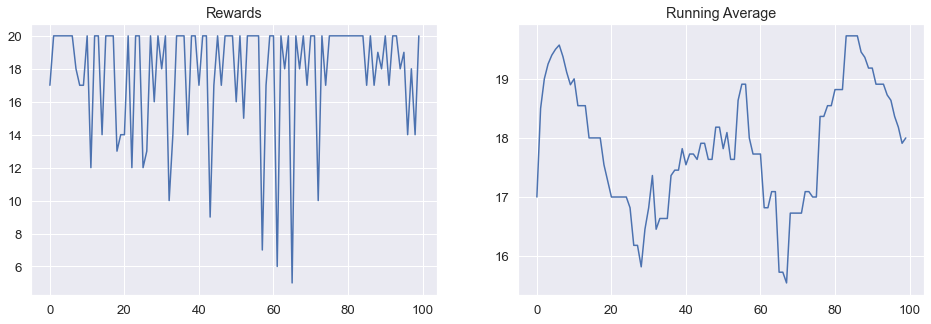

In [339]:
env = ToyMDP(state_dims=state_dims,
             action_dims=action_dims,
             obs_dims=obs_dims,
             max_steps_per_episode=10)

# rand_agent = RandomAgent(env)
pi_opt = compute_optimal_policy(env, gamma=gamma)
opt_agent = FixedPolicyAgent(env, pi=pi_opt)


ax0, ax1 = play_n_episodes(env, opt_agent, n=100, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

### LoanMDPV0

##### LoanMDPv0

In [9]:
class LoanMDPv0(MultiObjectiveDiscreteMDP):

    def _transition_probability(self, s, a):
        """
        Returns the probabilities of transitioning into all
        next states after taking action a in state s.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.

        Returns
        -------
        np.array<float>, shape(n_states)
            Transition probabilities.
        """
        trans_probs = np.zeros(self.n_states)
        z, y0, y1, c = self._state_to_feats[s]
        
        if c == 0 or a == 0:
            sp_z0y0y1c = self._feats_to_state[self._hash_features((0,y0,y1,c))]
            sp_z1y0y1c = self._feats_to_state[self._hash_features((1,y0,y1,c))]
            trans_probs[sp_z0y0y1c] = 1/2
            trans_probs[sp_z1y0y1c] = 1/2
        elif c > 0:
            # Set repayment probabilities
            z0y0_prob_repay = 1/4
            z1y0_prob_repay = 1/2
            z0y1_prob_repay = 3/4
            z1y1_prob_repay = 2/3
            
            # Disadvantaged group
            if z == 0:
                p_repay = z0y0_prob_repay if y0 == 0 else z0y1_prob_repay
                c_repay = min([c + 1, 2])
                c_default = c - 1
                # Repay states
                spz0 = self._feats_to_state[self._hash_features((0,1,y1,c_repay))]
                spz1 = self._feats_to_state[self._hash_features((1,1,y1,c_repay))]
                trans_probs[spz0] = p_repay / 2
                trans_probs[spz1] = p_repay / 2
                # Default states
                spz0 = self._feats_to_state[self._hash_features((0,0,y1,c_default))]
                spz1 = self._feats_to_state[self._hash_features((1,0,y1,c_default))]
                trans_probs[spz0] = (1-p_repay) / 2
                trans_probs[spz1] = (1-p_repay) / 2
                
            # Advantaged group
            else:
                p_repay = z1y0_prob_repay if y1 == 0 else z1y1_prob_repay
                c_repay = min([c + 1, 2])
                c_default = c - 1
                # Repay states
                spz0 = self._feats_to_state[self._hash_features((0,y0,1,c_repay))]
                spz1 = self._feats_to_state[self._hash_features((1,y0,1,c_repay))]
                trans_probs[spz0] = p_repay / 2
                trans_probs[spz1] = p_repay / 2
                # Default states
                spz0 = self._feats_to_state[self._hash_features((0,y0,0,c_default))]
                spz1 = self._feats_to_state[self._hash_features((1,y0,0,c_default))]
                trans_probs[spz0] = (1-p_repay) / 2
                trans_probs[spz1] = (1-p_repay) / 2

        return trans_probs
    
    def _init_state_probability(self, s):
        """
        Returns the probabily of starting in state s.

        Parameters
        ----------
        s : int
            Initial state index.

        Returns
        -------
        float, range(0,1)
            Initial state probability.
        """
        z, y0, y1, c = self._state_to_feats[s]
            
#         # Equal probability of any state where c=1.
#         if c == 1:
#             prob = self.state_dims[3]*(1. / self.n_states)
#         else:
#             prob = 0
            
        # Equal probability of any state where c=1, except that
        # z=0 has lower prob of y being 1.
        if c == 1:
            if z == 0:
                if y0 == 0:
                    prob = 1.5 * self.state_dims[3] / self.n_states
                else:
                    prob = 0.5 * self.state_dims[3] / self.n_states
            else:
                prob = self.state_dims[3] / self.n_states
        else:
            prob = 0
            
        return prob
    
    def _reward_sasl(self, s, a, sp, larr):
        """
        Returns the reward values for each of the l objectives obtained after
        taking action `a` in state `s` and transitioning into new state
        `sp`. Used to construct `Rsasl`.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.
        sp : int
            New state index.
        larr : array-like<int>
            Array of objective indexes.

        Returns
        -------
        np.array<float>
            rls. Array of reward values broken down by each objective.
        """
        z, y0, y1, c = self._state_to_feats[s]
        zp, y0p, y1p, cp = self._state_to_feats[sp]
        rls = np.empty(len(larr))
        
        # Compute rls[0] <- rc
        if a == 1:
            if cp > 0:
                if cp >= c:
                    rls[0] = 1
                else:
                    rls[0] = -1
            else:
                rls[0] = 0
        else:
            rls[0] = 0
            
        # Compute rls[1] <- rb
        rls[1] = y0 if z == 0 else y1
            
        # Compute rls[2] <- rf
        rls[2] = 1 - abs(y0 - y1)
            
        return rls
    
    def _observation_probability(self, s, a, sp):
        """
        Returns the probabilities of observing all observations after taking
        action a in state s and transitioning into state sp. Used to construct
        `Osaso`.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.
        sp : int
            New state index.

        Returns
        -------
        np.array<float>, shape(n_obs)
            Observation probabilities.
        """
        obs_probs = np.zeros(self.n_obs)
        sp_feats = self._state_to_feats[sp]
        
        for o in range(self.n_obs):
            o_feats = self._obs_to_feats[o]
            all_eq = True
            
            for i in range(len(o_feats)):
                if sp_feats[i] != o_feats[i]:
                    all_eq = False
                    
            obs_probs[o] = 1 if all_eq else 0
            
        return obs_probs

##### Shared parameters

In [10]:
"""
Env specific parameters
"""
state_dims = (2,2,2,3)
action_dims = (2,)
obs_dims = (2,2,2,3)
max_steps_per_episode = 10
gamma = 1 - (1/max_steps_per_episode)
n_episodes = 1_000

##### Random Policy

Constructing transition matrix...
Constructing observation matrix...
Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
episode: 0, total reward: 0.00, eps: 0.000, avg reward last 100: 0.000
episode: 100, total reward: 0.00, eps: 0.000, avg reward last 100: 0.782
episode: 200, total reward: 0.00, eps: 0.000, avg reward last 100: 1.099
episode: 300, total reward: 0.00, eps: 0.000, avg reward last 100: 1.059
episode: 400, total reward: 0.00, eps: 0.000, avg reward last 100: 1.109
episode: 500, total reward: 3.00, eps: 0.000, avg reward last 100: 1.099
episode: 600, total reward: 5.00, eps: 0.000, avg reward last 100: 0.980
episode: 700, total reward: 0.00, eps: 0.000, avg reward last 100: 1.446
episode: 800, total reward: 0.00, eps: 0.000, avg reward last 100: 0.891
episode: 900, total reward: 5.00, eps: 0.000, avg reward last 100: 1.158

Total steps: 1,000
Avg cumulative reward: 1.064
Avg reward for last 100 ep

NameError: name 'compute_metric' is not defined

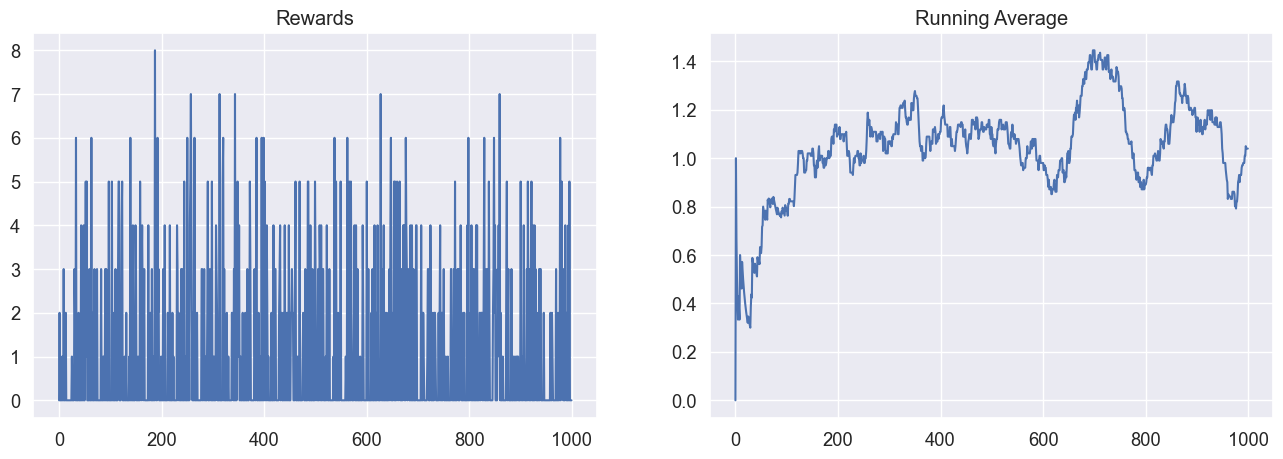

In [11]:
lc = 1
lb = 0
lf = 0

env = LoanMDPv0(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                obj_weights=[lc, lb, lf])

agent = RandomAgent(env)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy
_pi = env.render_policy(np.zeros(env.n_states), ['Z', 'Y0', 'Y1', 'C'])
# display(_pi.query('Z == 0'))
# display(_pi.query('Z == 1'))

# Compute metrics
metrics_by_t_rand = {}
metrics_by_t_rand['Y'] = compute_metric(env, lambda feats: feats[:,1:3].mean())
metrics_by_t_rand['Y0'] = compute_metric(env, lambda feats: feats[:,1].mean())
metrics_by_t_rand['Y1'] = compute_metric(env, lambda feats: feats[:,2].mean())
metrics_by_t_rand['C'] = compute_metric(env, lambda feats: feats[:,3].mean())

metric_aggs_rand = {}
metric_aggs_rand['Profit'] = np.mean([np.mean(env.moo_reward_episode_memory[1:][ep][1:][0]) for ep in range(1, len(env.reward_episode_memory)-1)])
metric_aggs_rand['MeanQual'] = metrics_by_t_rand['Y'].mean()
metric_aggs_rand['MeanQualDiff'] = np.abs(metrics_by_t_rand['Y1'] - metrics_by_t_rand['Y0']).mean()
metric_aggs_rand['MeanQualDis'] = metrics_by_t_rand['Y0'].mean()
metric_aggs_rand['MeanQualAdv'] = metrics_by_t_rand['Y1'].mean()
print()
for k in metric_aggs_rand:
    print(f'{k}: \t{metric_aggs_rand[k]:.3f}')

##### Optimal Policy ($\lambda^C=1, \lambda^B=0, \lambda^F=0$)

In [ ]:
Next steps: look at the distribution of `MeanQual`, `MeanQualDiff`, etc metrics for all optimal policies

episode: 0, total reward: 0.00, eps: 0.000, avg reward last 100: 0.000
episode: 100, total reward: 3.00, eps: 0.000, avg reward last 100: 2.040
episode: 200, total reward: 4.00, eps: 0.000, avg reward last 100: 1.436
episode: 300, total reward: 3.00, eps: 0.000, avg reward last 100: 1.842
episode: 400, total reward: 0.00, eps: 0.000, avg reward last 100: 1.782
episode: 500, total reward: 1.00, eps: 0.000, avg reward last 100: 1.901
episode: 600, total reward: 0.00, eps: 0.000, avg reward last 100: 2.010
episode: 700, total reward: 0.00, eps: 0.000, avg reward last 100: 1.366
episode: 800, total reward: 6.00, eps: 0.000, avg reward last 100: 1.653
episode: 900, total reward: 2.00, eps: 0.000, avg reward last 100: 1.772

Total steps: 1,000
Avg cumulative reward: 1.762
Avg reward for last 100 episodes: 1.850
0.0 Avg action of first episode

Profit: 	0.400
MeanQual: 	0.314
MeanQualDiff: 	0.180
MeanQualDis: 	0.224
MeanQualAdv: 	0.405


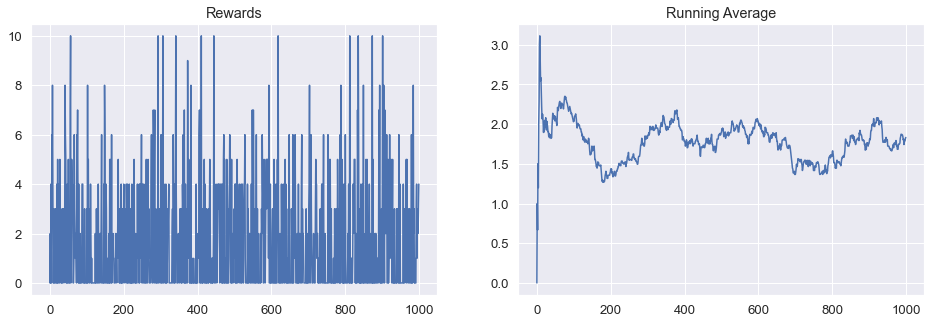

In [19]:
lc = 1
lb = 0
lf = 0

env = LoanMDPv0(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                obj_weights=[lc, lb, lf])

pis = compute_optimal_policy(env, gamma=gamma)

# Inspect differences in the optimal policies
for i, _ in enumerate(pis):
    print(f'pis[{i}]')
    diff = pis[i] - pis[0]
    for s in np.flatnonzero(diff):
        z, y0, y1, c = env._state_to_feats[s]
        print(f'\tz={z}, y0={y0}, y1={y1}, c={c}')    

pi = pis[0]
agent = FixedPolicyAgent(env, pi=pi)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy
_pi = env.render_policy(pi, ['Z', 'Y0', 'Y1', 'C'])
# display(_pi.query('Z == 0 and C > 0').sort_values(['Y0', 'C', 'Y1'], ascending=False))
# display(_pi.query('Z == 1 and C > 0').sort_values(['Y1', 'C', 'Y0'], ascending=False))

# Compute metrics
metrics_by_t_100 = {}
metrics_by_t_100['Y'] = compute_metric(env, lambda feats: feats[:,1:3].mean())
metrics_by_t_100['Y0'] = compute_metric(env, lambda feats: feats[:,1].mean())
metrics_by_t_100['Y1'] = compute_metric(env, lambda feats: feats[:,2].mean())
metrics_by_t_100['C'] = compute_metric(env, lambda feats: feats[:,3].mean())

metric_aggs_100 = {}
metric_aggs_100['Profit'] = np.mean([np.mean(env.moo_reward_episode_memory[1:][ep][1:][0]) for ep in range(1, len(env.reward_episode_memory)-1)])
metric_aggs_100['MeanQual'] = metrics_by_t_100['Y'].mean()
metric_aggs_100['MeanQualDiff'] = np.abs(metrics_by_t_100['Y1'] - metrics_by_t_100['Y0']).mean()
metric_aggs_100['MeanQualDis'] = metrics_by_t_100['Y0'].mean()
metric_aggs_100['MeanQualAdv'] = metrics_by_t_100['Y1'].mean()
print()
for k in metric_aggs_100:
    print(f'{k}: \t{metric_aggs_100[k]:.3f}')

##### Optimal Policy ($\lambda^C=1, \lambda^B=1, \lambda^F=0$)

In [18]:
lc = 1
lb = 1
lf = 0

env = LoanMDPv0(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                obj_weights=[lc, lb, lf])

pi = compute_optimal_policy(env, gamma=gamma)
agent = FixedPolicyAgent(env, pi=pi)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy
_pi = env.render_policy(pi, ['Z', 'Y0', 'Y1', 'C'])
# display(_pi.query('Z == 0 and C > 0').sort_values('Y0'))
# display(_pi.query('Z == 1 and C > 0').sort_values('Y1'))

# Compute metrics
metrics_by_t_110 = {}
metrics_by_t_110['Y'] = compute_metric(env, lambda feats: feats[:,1:3].mean())
metrics_by_t_110['Y0'] = compute_metric(env, lambda feats: feats[:,1].mean())
metrics_by_t_110['Y1'] = compute_metric(env, lambda feats: feats[:,2].mean())
metrics_by_t_110['C'] = compute_metric(env, lambda feats: feats[:,3].mean())

metric_aggs_110 = {}
metric_aggs_110['Profit'] = np.mean([np.mean(env.moo_reward_episode_memory[1:][ep][1:][0]) for ep in range(1, len(env.reward_episode_memory)-1)])
metric_aggs_110['MeanQual'] = metrics_by_t_110['Y'].mean()
metric_aggs_110['MeanQualDiff'] = np.abs(metrics_by_t_110['Y1'] - metrics_by_t_110['Y0']).mean()
metric_aggs_110['MeanQualDis'] = metrics_by_t_110['Y0'].mean()
metric_aggs_110['MeanQualAdv'] = metrics_by_t_110['Y1'].mean()
print()
for k in metric_aggs_110:
    print(f'{k}: \t{metric_aggs_110[k]:.3f}')

ValueError: object too deep for desired array

##### Optimal Policy ($\lambda^C=1, \lambda^B=1, \lambda^F=1$)

episode: 0, total reward: 3.33, eps: 0.000, avg reward last 100: 3.333
episode: 100, total reward: 6.33, eps: 0.000, avg reward last 100: 4.333
episode: 200, total reward: 6.67, eps: 0.000, avg reward last 100: 3.901
episode: 300, total reward: 6.33, eps: 0.000, avg reward last 100: 4.310
episode: 400, total reward: 6.67, eps: 0.000, avg reward last 100: 4.376
episode: 500, total reward: 3.33, eps: 0.000, avg reward last 100: 4.020
episode: 600, total reward: 6.33, eps: 0.000, avg reward last 100: 4.409
episode: 700, total reward: 3.00, eps: 0.000, avg reward last 100: 4.165
episode: 800, total reward: 2.67, eps: 0.000, avg reward last 100: 4.142
episode: 900, total reward: 1.67, eps: 0.000, avg reward last 100: 4.347

Total steps: 1,000
Avg cumulative reward: 4.181
Avg reward for last 100 episodes: 3.853
0.18181818181818182 Avg action of first episode

Profit: 	0.397
MeanQual: 	0.477
MeanQualDiff: 	0.069
MeanQualDis: 	0.450
MeanQualAdv: 	0.505


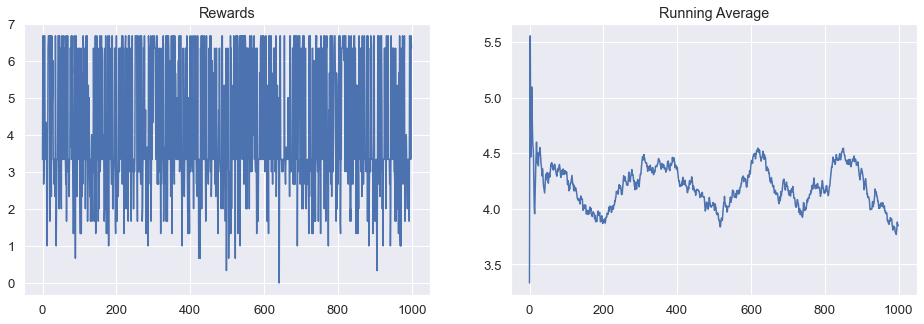

In [171]:
lc = 1
lb = 1
lf = 1
env = LoanMDPv0(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                obj_weights=[lc, lb, lf])

pi = compute_optimal_policy(env, gamma=gamma)
agent = FixedPolicyAgent(env, pi=pi)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy
_pi = env.render_policy(pi, ['Z', 'Y0', 'Y1', 'C'])
# display(_pi.query('Z == 0'))
# display(_pi.query('Z == 1'))

# Compute metrics
metrics_by_t_111 = {}
metrics_by_t_111['Y'] = compute_metric(env, lambda feats: feats[:,1:3].mean())
metrics_by_t_111['Y0'] = compute_metric(env, lambda feats: feats[:,1].mean())
metrics_by_t_111['Y1'] = compute_metric(env, lambda feats: feats[:,2].mean())
metrics_by_t_111['C'] = compute_metric(env, lambda feats: feats[:,3].mean())

metric_aggs_111 = {}
metric_aggs_111['Profit'] = np.mean([np.mean(env.moo_reward_episode_memory[1:][ep][1:][0]) for ep in range(1, len(env.reward_episode_memory)-1)])
metric_aggs_111['MeanQual'] = metrics_by_t_111['Y'].mean()
metric_aggs_111['MeanQualDiff'] = np.abs(metrics_by_t_111['Y1'] - metrics_by_t_111['Y0']).mean()
metric_aggs_111['MeanQualDis'] = metrics_by_t_111['Y0'].mean()
metric_aggs_111['MeanQualAdv'] = metrics_by_t_111['Y1'].mean()
print()
for k in metric_aggs_111:
    print(f'{k}: \t{metric_aggs_111[k]:.3f}')

In [172]:
##### Optimal Policy ($\lambda^C=1, \lambda^B=0, \lambda^F=1$)

episode: 0, total reward: 4.00, eps: 0.000, avg reward last 100: 4.000
episode: 100, total reward: 5.00, eps: 0.000, avg reward last 100: 4.015
episode: 200, total reward: 5.00, eps: 0.000, avg reward last 100: 4.213
episode: 300, total reward: 5.00, eps: 0.000, avg reward last 100: 4.015
episode: 400, total reward: 5.00, eps: 0.000, avg reward last 100: 4.109
episode: 500, total reward: 5.00, eps: 0.000, avg reward last 100: 4.267
episode: 600, total reward: 4.00, eps: 0.000, avg reward last 100: 4.173
episode: 700, total reward: 4.50, eps: 0.000, avg reward last 100: 4.163
episode: 800, total reward: 1.50, eps: 0.000, avg reward last 100: 4.144
episode: 900, total reward: 5.00, eps: 0.000, avg reward last 100: 4.129

Total steps: 1,000
Avg cumulative reward: 4.142
Avg reward for last 100 episodes: 4.220
0.0 Avg action of first episode

Profit: 	0.347
MeanQual: 	0.355
MeanQualDiff: 	0.054
MeanQualDis: 	0.328
MeanQualAdv: 	0.382


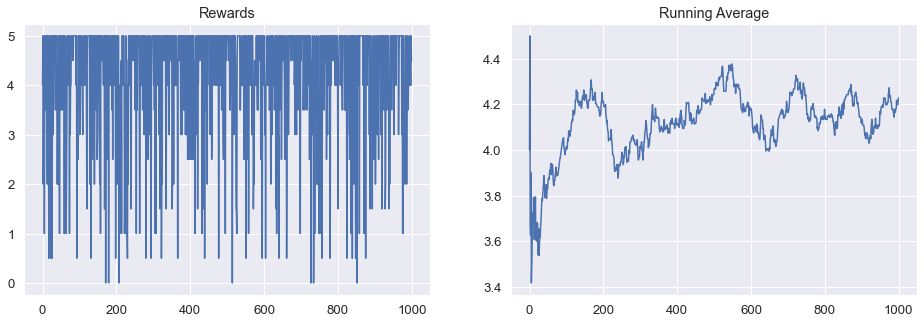

In [173]:
lc = 1
lb = 0
lf = 1
env = LoanMDPv0(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                obj_weights=[lc, lb, lf])

pi = compute_optimal_policy(env, gamma=gamma)
agent = FixedPolicyAgent(env, pi=pi)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy
_pi = env.render_policy(pi, ['Z', 'Y0', 'Y1', 'C'])
# display(_pi.query('Z == 0'))
# display(_pi.query('Z == 1'))

# Compute metrics
metrics_by_t_101 = {}
metrics_by_t_101['Y'] = compute_metric(env, lambda feats: feats[:,1:3].mean())
metrics_by_t_101['Y0'] = compute_metric(env, lambda feats: feats[:,1].mean())
metrics_by_t_101['Y1'] = compute_metric(env, lambda feats: feats[:,2].mean())
metrics_by_t_101['C'] = compute_metric(env, lambda feats: feats[:,3].mean())

metric_aggs_101 = {}
metric_aggs_101['Profit'] = np.mean([np.mean(env.moo_reward_episode_memory[1:][ep][1:][0]) for ep in range(1, len(env.reward_episode_memory)-1)])
metric_aggs_101['MeanQual'] = metrics_by_t_101['Y'].mean()
metric_aggs_101['MeanQualDiff'] = np.abs(metrics_by_t_101['Y1'] - metrics_by_t_101['Y0']).mean()
metric_aggs_101['MeanQualDis'] = metrics_by_t_101['Y0'].mean()
metric_aggs_101['MeanQualAdv'] = metrics_by_t_101['Y1'].mean()
print()
for k in metric_aggs_101:
    print(f'{k}: \t{metric_aggs_101[k]:.3f}')

##### Compare

In [174]:
metrics_labels = [
#     (metrics_by_t_rand, metric_aggs_rand,  'Random', 'Rand'),
    (metrics_by_t_100, metric_aggs_100, 'Optimal $\lambda=(1,0,0)$', 'lambda_100'),
#     (metrics_by_t_110, metric_aggs_110, 'Optimal $\lambda=(1,1,0)$', 'lambda_110'),
#     (metrics_by_t_111, metric_aggs_111, 'Optimal $\lambda=(1,1,1)$', 'lambda_111'),
    (metrics_by_t_101, metric_aggs_101, 'Optimal $\lambda=(1,0,1)$', 'lambda_101'),
]

,Algo,Profit,MeanQual,MeanQualDiff,MeanQualDis,MeanQualAdv
0,lambda_100,0.418,0.311,0.149,0.237,0.386
1,lambda_101,0.347,0.355,0.054,0.328,0.382


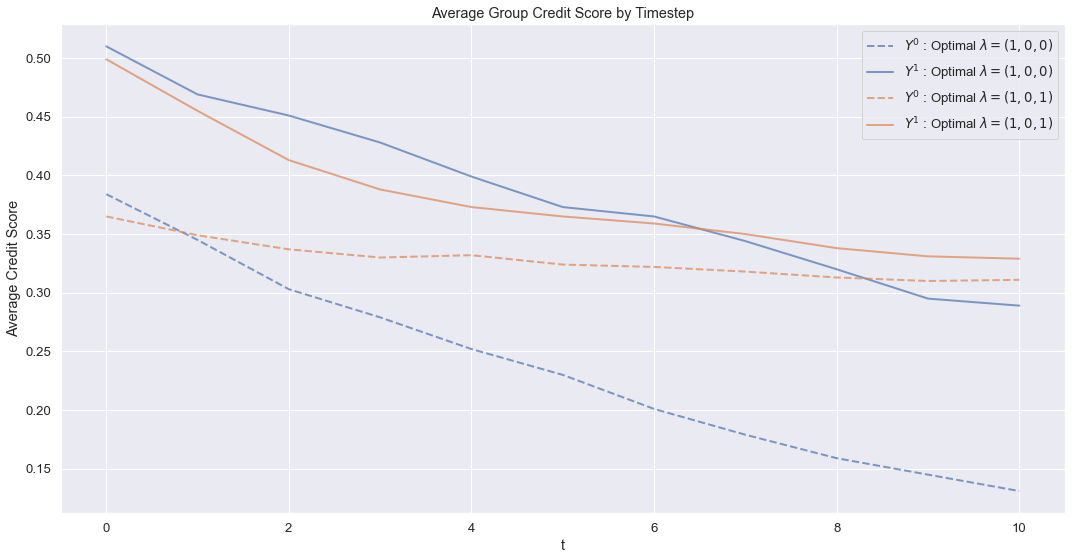

In [175]:
import pandas as pd


# Plot avg credit scores over time
fig, ax = plt.subplots(1, 1, figsize=(18, 9))

ls_patterns = ['--', '-']

results_table = []
    
for i, (metrics_by_t, metric_aggs, label, short_label) in enumerate(metrics_labels):
    ax.plot(
        np.arange(len(metrics_by_t['Y0'])),
        metrics_by_t['Y0'],
        label=f'$Y^0$ : {label}',
        c=sns.color_palette()[i],
        ls=ls_patterns[0],
        lw=2,
        alpha=.7)
    ax.plot(
        np.arange(len(metrics_by_t['Y1'])),
        metrics_by_t['Y1'],
        label=f'$Y^1$ : {label}',
        c=sns.color_palette()[i],
        ls=ls_patterns[1],
        lw=2,
        alpha=.7)
    
    results_table.append(np.array([short_label] + [metric_aggs[k].round(3) for k in metric_aggs]))
    
results_table = np.array(results_table)
results_table = pd.DataFrame(results_table, columns=['Algo'] + [k for k in metrics_labels[0][1]])
display(results_table)

ax.set_xlabel('t')
ax.set_ylabel('Average Credit Score')
ax.set_title('Average Group Credit Score by Timestep')
ax.legend()
plt.show()

In [162]:
# # Plot avg cost over time
# fig, ax = plt.subplots(1, 1, figsize=(18, 9))

# ls_patterns = ['-']
    
# for i, (metrics, label) in enumerate(metrics_labels):
#     ax.plot(
#         np.arange(len(metrics['C'])),
#         metrics['C'],
#         label=f'$C$ : {label}',
#         c=sns.color_palette()[i],
#         ls=ls_patterns[0],
#         lw=3,
#         alpha=.7)

# ax.set_xlabel('t')
# ax.set_ylabel('Average Cost')
# ax.set_title('Average Cost by Timestep')
# ax.legend()
# plt.show()

### Loan MDP V1

##### LoanMDPV1

In [61]:
# These functions are only for testing purposes. They can be deleted.

def _hash_yd(y0, y1, prev_yd, y_dims, max_steps_per_episode):
    """
    Computes the yd (ydelta) index value. Since the index must be a positive
    integer, this transformation is necessary.

    Tests
    -----
        assert hash_yd(y0=0, y1=0, prev_yd=20, y_dims=3, max_steps_per_episode=10) == 20
        assert hash_yd(y0=0, y1=2, prev_yd=20, y_dims=3, max_steps_per_episode=10) == 22
        assert hash_yd(y0=0, y1=0, prev_yd=22, y_dims=3, max_steps_per_episode=10) == 22
    """
    diff = y1 - y0
    return prev_yd + diff

assert _hash_yd(y0=0, y1=0, prev_yd=20, y_dims=3, max_steps_per_episode=10) == 20
assert _hash_yd(y0=0, y1=2, prev_yd=20, y_dims=3, max_steps_per_episode=10) == 22
assert _hash_yd(y0=0, y1=0, prev_yd=22, y_dims=3, max_steps_per_episode=10) == 22


def _unhash_yd(yd, y_dims, max_steps_per_episode):
    """
    Computes the actual ydelta value based on the hashed ydelta index.
    Inverse of _hash_yd().

    Tests
    -----
        assert _unhash_yd(yd=0, y_dims=3, max_steps_per_episode=10) == -20
        assert _unhash_yd(yd=20, y_dims=3, max_steps_per_episode=10) == 0
        assert _unhash_yd(yd=40, y_dims=3, max_steps_per_episode=10) == 20
    """
    offset = (y_dims-1) * max_steps_per_episode
    ydelta = yd - offset
    return ydelta

assert _unhash_yd(yd=0, y_dims=3, max_steps_per_episode=10) == -20
assert _unhash_yd(yd=20, y_dims=3, max_steps_per_episode=10) == 0
assert _unhash_yd(yd=40, y_dims=3, max_steps_per_episode=10) == 20

del _hash_yd, _unhash_yd

In [62]:
class LoanMDPv1(MultiObjectiveDiscreteMDP):

    def _hash_yd(self, y0, y1, prev_yd):
        """
        Computes the yd (ydelta) index value. Since the index must be a positive
        integer, this transformation is necessary.
        
        Tests
        -----
            assert hash_yd(y0=0, y1=0, prev_yd=20, y_dims=3, max_steps_per_episode=10) == 20
            assert hash_yd(y0=0, y1=2, prev_yd=20, y_dims=3, max_steps_per_episode=10) == 22
            assert hash_yd(y0=0, y1=0, prev_yd=22, y_dims=3, max_steps_per_episode=10) == 22
        """
        diff = y1 - y0
        return prev_yd + diff
    
    def _unhash_yd(self, yd):
        """
        Computes the actual ydelta value based on the hashed ydelta index.
        Inverse of _hash_yd().
        
        Tests
        -----
            assert _unhash_yd(yd=0, y_dims=3, max_steps_per_episode=10) == -20
            assert _unhash_yd(yd=20, y_dims=3, max_steps_per_episode=10) == 0
            assert _unhash_yd(yd=40, y_dims=3, max_steps_per_episode=10) == 20
        """
        y_dims = self.state_dims[1]
        offset = (y_dims-1) * self.max_steps_per_episode
        ydelta = yd - offset
        return ydelta

    def _transition_probability(self, s, a):
        """
        Returns the probabilities of transitioning into all
        next states after taking action a in state s.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.

        Returns
        -------
        np.array<float>, shape(n_states)
            Transition probabilities.
        """
        trans_probs = np.zeros(self.n_states)
        z, y0, y1, c, yd = self._state_to_feats[s]
        
        # If s is an impossible state
        # Then return equal probabilities for all subsequent states
        yd_max = self.state_dims[4] - 1
        yd_min = 0
        if (yd > yd_max - (self.state_dims[2]-1)) or (
            yd < yd_min + (self.state_dims[2]-1)):
            trans_probs = np.ones(self.n_states) / self.n_states
            return trans_probs
        
        # If no cash available or previous action=rejected
        if c == 0 or a == 0:
            # Y^0 and Y1 can increase iff Y^0 == 1
            if z == 0 and y0 == 1:
                sp_z0y0eq2y1c = self._feats_to_state[self._hash_features((0,2,y1,c,self._hash_yd(2,y1,yd)))]
                sp_z1y0eq2y1c = self._feats_to_state[self._hash_features((1,2,y1,c,self._hash_yd(2,y1,yd)))]
                sp_z0y0eq1y1c = self._feats_to_state[self._hash_features((0,1,y1,c,self._hash_yd(1,y1,yd)))]
                sp_z1y0eq1y1c = self._feats_to_state[self._hash_features((1,1,y1,c,self._hash_yd(1,y1,yd)))]
                trans_probs[sp_z0y0eq2y1c] = self.args['notappr_pz0y1_incr'] / 2
                trans_probs[sp_z1y0eq2y1c] = self.args['notappr_pz0y1_incr'] / 2
                trans_probs[sp_z0y0eq1y1c] = (1-self.args['notappr_pz0y1_incr']) / 2
                trans_probs[sp_z1y0eq1y1c] = (1-self.args['notappr_pz0y1_incr']) / 2
            elif z == 1 and y1 == 1:
                sp_z0y0y1eq2c = self._feats_to_state[self._hash_features((0,y0,2,c,self._hash_yd(y0,2,yd)))]
                sp_z1y0y1eq2c = self._feats_to_state[self._hash_features((1,y0,2,c,self._hash_yd(y0,2,yd)))]
                sp_z0y0y1eq1c = self._feats_to_state[self._hash_features((0,y0,1,c,self._hash_yd(y0,1,yd)))]
                sp_z1y0y1eq1c = self._feats_to_state[self._hash_features((1,y0,1,c,self._hash_yd(y0,1,yd)))]
                trans_probs[sp_z0y0y1eq2c] = self.args['notappr_pz1y1_incr'] / 2
                trans_probs[sp_z1y0y1eq2c] = self.args['notappr_pz1y1_incr'] / 2
                trans_probs[sp_z0y0y1eq1c] = (1-self.args['notappr_pz1y1_incr']) / 2
                trans_probs[sp_z1y0y1eq1c] = (1-self.args['notappr_pz1y1_incr']) / 2
            else:
                # No change to Y0, Y1, or C
                sp_z0y0y1c = self._feats_to_state[self._hash_features((0,y0,y1,c,self._hash_yd(y0,y1,yd)))]
                sp_z1y0y1c = self._feats_to_state[self._hash_features((1,y0,y1,c,self._hash_yd(y0,y1,yd)))]
                trans_probs[sp_z0y0y1c] = 1/2
                trans_probs[sp_z1y0y1c] = 1/2
                
        # If cash available and action=approve
        else:
            # Disadvantaged group
            if z == 0:
                if y0 == 0:
                    p_repay = self.args['z0y0_prob_repay']
                elif y0 == 1:
                    p_repay = self.args['z0y1_prob_repay']
                else:
                    p_repay = self.args['z0y2_prob_repay']
                    
                c_repay = min([c + 1, self.state_dims[3]-1])
                c_default = c - 1
                
                # Repay states
                if y0 == 1:
                    spz0y0 = self._feats_to_state[self._hash_features((0,0,y1,c_repay,self._hash_yd(0,y1,yd)))]
                    spz0y1 = self._feats_to_state[self._hash_features((0,1,y1,c_repay,self._hash_yd(1,y1,yd)))]
                    spz0y2 = self._feats_to_state[self._hash_features((0,2,y1,c_repay,self._hash_yd(2,y1,yd)))]
                    spz1y0 = self._feats_to_state[self._hash_features((1,0,y1,c_repay,self._hash_yd(0,y1,yd)))]
                    spz1y1 = self._feats_to_state[self._hash_features((1,1,y1,c_repay,self._hash_yd(1,y1,yd)))]
                    spz1y2 = self._feats_to_state[self._hash_features((1,2,y1,c_repay,self._hash_yd(2,y1,yd)))]
                    trans_probs[spz0y0] = 1/2 * p_repay * self.args['z0y1_repaid_decr_prob']
                    trans_probs[spz0y1] = 1/2 * p_repay * (1 - self.args['z0y1_repaid_incr_prob'] - self.args['z0y1_repaid_decr_prob'])
                    trans_probs[spz0y2] = 1/2 * p_repay * self.args['z0y1_repaid_incr_prob']
                    trans_probs[spz1y0] = 1/2 * p_repay * self.args['z0y1_repaid_decr_prob']
                    trans_probs[spz1y1] = 1/2 * p_repay * (1 - self.args['z0y1_repaid_incr_prob'] - self.args['z0y1_repaid_decr_prob'])
                    trans_probs[spz1y2] = 1/2 * p_repay * self.args['z0y1_repaid_incr_prob']
                else:
                    y0_repaid = min(self.state_dims[1]-1, y0+1)
                    spz0 = self._feats_to_state[self._hash_features((0,y0_repaid,y1,c_repay,self._hash_yd(y0_repaid,y1,yd)))]
                    spz1 = self._feats_to_state[self._hash_features((1,y0_repaid,y1,c_repay,self._hash_yd(y0_repaid,y1,yd)))]
                    trans_probs[spz0] = p_repay / 2
                    trans_probs[spz1] = p_repay / 2

                # Default states
                y0_defaulted = max(0, y0-1)
                spz0 = self._feats_to_state[self._hash_features((0,y0_defaulted,y1,c_default,self._hash_yd(y0_defaulted,y1,yd)))]
                spz1 = self._feats_to_state[self._hash_features((1,y0_defaulted,y1,c_default,self._hash_yd(y0_defaulted,y1,yd)))]
                trans_probs[spz0] = (1-p_repay) / 2
                trans_probs[spz1] = (1-p_repay) / 2
                
            # Advantaged group
            else:
                if y1 == 0:
                    p_repay = self.args['z1y0_prob_repay']
                elif y1 == 1:
                    p_repay = self.args['z1y1_prob_repay']
                else:
                    p_repay = self.args['z1y2_prob_repay']
                    
                c_repay = min([c + 1, self.state_dims[3]-1])
                c_default = c - 1
                    
                # Repay states
                if y1 == 1:
                    spz0y0 = self._feats_to_state[self._hash_features((0,y0,0,c_repay,self._hash_yd(y0,0,yd)))]
                    spz0y1 = self._feats_to_state[self._hash_features((0,y0,1,c_repay,self._hash_yd(y0,1,yd)))]
                    spz0y2 = self._feats_to_state[self._hash_features((0,y0,2,c_repay,self._hash_yd(y0,2,yd)))]
                    spz1y0 = self._feats_to_state[self._hash_features((1,y0,0,c_repay,self._hash_yd(y0,0,yd)))]
                    spz1y1 = self._feats_to_state[self._hash_features((1,y0,1,c_repay,self._hash_yd(y0,1,yd)))]
                    spz1y2 = self._feats_to_state[self._hash_features((1,y0,2,c_repay,self._hash_yd(y0,2,yd)))]
                    trans_probs[spz0y0] = 1/2 * p_repay * self.args['z1y1_repaid_decr_prob']
                    trans_probs[spz0y1] = 1/2 * p_repay * (1 - self.args['z1y1_repaid_incr_prob'] - self.args['z1y1_repaid_decr_prob'])
                    trans_probs[spz0y2] = 1/2 * p_repay * self.args['z1y1_repaid_incr_prob']
                    trans_probs[spz1y0] = 1/2 * p_repay * self.args['z1y1_repaid_decr_prob']
                    trans_probs[spz1y1] = 1/2 * p_repay * (1 - self.args['z1y1_repaid_incr_prob'] - self.args['z1y1_repaid_decr_prob'])
                    trans_probs[spz1y2] = 1/2 * p_repay * self.args['z1y1_repaid_incr_prob']
                else:
                    y1_repaid = min(self.state_dims[2]-1, y1+1)
                    spz0 = self._feats_to_state[self._hash_features((0,y0,y1_repaid,c_repay,self._hash_yd(y0,y1_repaid,yd)))]
                    spz1 = self._feats_to_state[self._hash_features((1,y0,y1_repaid,c_repay,self._hash_yd(y0,y1_repaid,yd)))]
                    trans_probs[spz0] = p_repay / 2
                    trans_probs[spz1] = p_repay / 2

                # Default states
                y1_defaulted = max(0, y1-1)
                spz0 = self._feats_to_state[self._hash_features((0,y0,y1_defaulted,c_default,self._hash_yd(y0,y1_defaulted,yd)))]
                spz1 = self._feats_to_state[self._hash_features((1,y0,y1_defaulted,c_default,self._hash_yd(y0,y1_defaulted,yd)))]
                trans_probs[spz0] = (1-p_repay) / 2
                trans_probs[spz1] = (1-p_repay) / 2

        return trans_probs
    
    def _init_state_probability(self, s):
        """
        Returns the probabily of starting in state s.

        Parameters
        ----------
        s : int
            Initial state index.

        Returns
        -------
        float, range(0,1)
            Initial state probability.
        """
        z, y0, y1, c, yd = self._state_to_feats[s]
        ydelta = self._unhash_yd(yd)
            
        # Equal probability of any state where c=1 and ydelta is correct.
        if c == 1 and ydelta == (y1 - y0):
            prob = self.state_dims[3]*self.state_dims[4]*(1. / self.n_states)
        else:
            prob = 0
            
        # Equal probability of any state where c=1, except that
        # z=0 has lower prob of y being 1.
#         if c == 1:
#             if z == 0:
#                 if y0 == 0:
#                     prob = 1.5 * self.state_dims[3] / self.n_states
#                 else:
#                     prob = 0.5 * self.state_dims[3] / self.n_states
#             else:
#                 prob = self.state_dims[3] / self.n_states
#         else:
#             prob = 0
            
        return prob
    
    def _reward_sasl(self, s, a, sp, larr):
        """
        Returns the reward values for each of the l objectives obtained after
        taking action `a` in state `s` and transitioning into new state
        `sp`. Used to construct `Rsasl`.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.
        sp : int
            New state index.
        larr : array-like<int>
            Array of objective indexes.

        Returns
        -------
        np.array<float>
            rls. Array of reward values broken down by each objective.
        """
        z, y0, y1, c, yd = self._state_to_feats[s]
        zp, y0p, y1p, cp, ydp = self._state_to_feats[sp]
        rls = np.empty(len(larr))
        
        # Cost component. Compute rls[0] <- rc
        if a == 1:
            if cp >= c:
                rls[0] = 1
            else:
                rls[0] = 0
        else:
            rls[0] = 0
            
        # Qualification component. Compute rls[1] <- rb
#         rls[1] = y0p if zp == 0 else y1p
        rls[1] = .5 * (y0p + y1p) / (self.state_dims[1]-1)
            
        # Fairness component. Compute rls[2] <- rf
#         rls[2] = 1 - abs(y0p - y1p)
        ydelta = self._unhash_yd(yd)
        ydeltap = self._unhash_yd(ydp)
        rls[2] = .5 + .5*((abs(ydelta) - abs(ydeltap)) / (self.state_dims[1]-1))
            
        return rls
    
    def _observation_probability(self, s, a, sp):
        """
        Returns the probabilities of observing all observations after taking
        action a in state s and transitioning into state sp. Used to construct
        `Osaso`.

        Parameters
        ----------
        s : int
            Initial state index.
        a : int
            Action index.
        sp : int
            New state index.

        Returns
        -------
        np.array<float>, shape(n_obs)
            Observation probabilities.
        """
        obs_probs = np.zeros(self.n_obs)
        sp_feats = self._state_to_feats[sp]
        sp_feats_hash = self._hash_features(sp_feats)
        obs_idx = self._feats_to_obs[sp_feats_hash]
        obs_probs[obs_idx] = 1
        return obs_probs

##### Shared parameters

In [97]:
"""
Env specific parameters
"""
EXPERIMENT_NAME = 'max_steps_per_episode_4'

max_steps_per_episode = 4
Osaso_dtype = 'int8'
n_episodes = 1_000

z_dims = 2
y_dims= 3
c_dims = 3
yd_dims = 2*(y_dims-1)*(max_steps_per_episode+1) + 1  # (max_steps_per_episode+1): need the +1 since s,a,s' always yields one extra s' than # timesteps
state_dims = (z_dims,y_dims,y_dims,c_dims,yd_dims)
action_dims = (2,)
obs_dims = state_dims
gamma = 1 - (1/max_steps_per_episode)

env_args =  {
    # Set repayment probabilities
    'z0y0_prob_repay': 1/4,
    'z1y0_prob_repay': 1/4,
    'z0y1_prob_repay': 2/3,
    'z1y1_prob_repay': 2/3,
    'z0y2_prob_repay': 3/4,
    'z1y2_prob_repay': 3/4,
    # Qualification dynamics
        # Prob of Y incr if no loan
        'notappr_pz0y1_incr': 0,
        'notappr_pz1y1_incr': 0,
        # Prob of Y incr upon repay (only when Y==1)
        'z0y1_repaid_incr_prob': 0,
        'z1y1_repaid_incr_prob': 1,
        # Prob of Y decr upon repay (only when Y==1)
        'z0y1_repaid_decr_prob': 1,
        'z1y1_repaid_decr_prob': 0,
}

##### Define, Reset metrics

In [108]:
TAU = 1

metrics_by_t_catalog = [
    # Show?, pos_metric?
    (True, True, 'Y0',  lambda df: df.groupby('timestep')[['y0']].mean()),
    (True, True, 'Y1',  lambda df: df.groupby('timestep')[['y1']].mean()),
]

metrics_by_ep_catalog = [
    # Show?, pos_metric?
    (True, True, 'R^C/ep', lambda df: df.groupby(['episode'])[['r0']].sum()['r0'].mean()),
    (True, True, 'R^Q/ep', lambda df: df.groupby(['episode'])[['r1']].sum()['r1'].mean()),
    (True, True, 'R^F/ep', lambda df: df.groupby(['episode'])[['r2']].sum()['r2'].mean()),
    (True, True, 'R^C/ep std', lambda df: df.groupby(['episode'])[['r0']].sum()['r0'].std()),
    (True, True, 'R^Q/ep std', lambda df: df.groupby(['episode'])[['r1']].sum()['r1'].std()),
    (True, True, 'R^F/ep std', lambda df: df.groupby(['episode'])[['r2']].sum()['r2'].std()),
    (True, True, 'R^C/ep p05', lambda df: df.groupby(['episode'])[['r0']].sum()['r0'].quantile(q=.05)),
    (True, True, 'R^Q/ep p05', lambda df: df.groupby(['episode'])[['r1']].sum()['r1'].quantile(q=.05)),
    (True, True, 'R^F/ep p05', lambda df: df.groupby(['episode'])[['r2']].sum()['r2'].quantile(q=.05)),
    (True, True, 'R^C/ep p95', lambda df: df.groupby(['episode'])[['r0']].sum()['r0'].quantile(q=.95)),
    (True, True, 'R^Q/ep p95', lambda df: df.groupby(['episode'])[['r1']].sum()['r1'].quantile(q=.95)),
    (True, True, 'R^F/ep p95', lambda df: df.groupby(['episode'])[['r2']].sum()['r2'].quantile(q=.95)),
    
    (False, True, 'Profit/t', lambda df: df['r0'].mean()),
    (True, True, 'Y0 AVG', lambda df: df['y0'].mean()),
    (True, True, 'Y1 AVG', lambda df: df['y1'].mean()),
    (True, True, 'Y0 AVG p05', lambda df: df['y0'].quantile(q=.05)),
    (True, True, 'Y1 AVG p05', lambda df: df['y1'].quantile(q=.05)),
    (True, True, 'Y0 AVG p95', lambda df: df['y0'].quantile(q=.95)),
    (True, True, 'Y1 AVG p95', lambda df: df['y1'].quantile(q=.95)),
    (True, True, 'Y0 std', lambda df: df['y0'].std()),
    (True, True, 'Y1 std', lambda df: df['y1'].std()),
    
    
    (True, True, 'Y0 FINAL', lambda df: df.groupby(['episode'])['y0'].tail(1).mean()),
    (True, True, 'Y1 FINAL', lambda df: df.groupby(['episode'])['y1'].tail(1).mean()),
    (True, True, 'Y0 FINAL std', lambda df: df.groupby(['episode'])['y0'].tail(1).std()),
    (True, True, 'Y1 FINAL std', lambda df: df.groupby(['episode'])['y1'].tail(1).std()),
    (True, True, 'Y0 FINAL p05', lambda df: df.groupby(['episode'])['y0'].tail(1).quantile(q=.05)),
    (True, True, 'Y1 FINAL p05', lambda df: df.groupby(['episode'])['y1'].tail(1).quantile(q=.05)),
    (True, True, 'Y0 FINAL p95', lambda df: df.groupby(['episode'])['y0'].tail(1).quantile(q=.95)),
    (True, True, 'Y1 FINAL p95', lambda df: df.groupby(['episode'])['y1'].tail(1).quantile(q=.95)),
     
    (True, False, '|Y1-Y0| AVG', lambda df: np.abs(df['y1'] - df['y0']).mean()),
    (True, False, '|Y1-Y0| std', lambda df: np.abs(df['y1'] - df['y0']).std()),
    (True, False, '|Y1-Y0| AVG p05', lambda df: np.abs(df['y1'] - df['y0']).quantile(q=.05)),
    (True, False, '|Y1-Y0| AVG p95', lambda df: np.abs(df['y1'] - df['y0']).quantile(q=.95)),
     
    (True, False, '|Y1-Y0| FINAL', lambda df: np.mean(np.abs(df.groupby(['episode'])['y1'].tail(1) - df.groupby(['episode'])['y0'].tail(1)))),
    (True, False, '|Y1-Y0| FINAL std', lambda df: np.std(np.abs(df.groupby(['episode'])['y1'].tail(1) - df.groupby(['episode'])['y0'].tail(1)))),
    (True, False, '|Y1-Y0| FINAL p05', lambda df: np.quantile(np.abs(df.groupby(['episode'])['y1'].tail(1) - df.groupby(['episode'])['y0'].tail(1)), q=.05)),
    (True, False, '|Y1-Y0| FINAL p95', lambda df: np.quantile(np.abs(df.groupby(['episode'])['y1'].tail(1) - df.groupby(['episode'])['y0'].tail(1)), q=.95)),
    
    (False, True, 'Z0 Loans Appr / ep', lambda df: df.query('z == 0 and a == 1 and c > 0').shape[0]),
    (False, True, 'Z1 Loans Appr / ep', lambda df: df.query('z == 1 and a == 1 and c > 0').shape[0]),
    (False, False, 'Z0 Loans Rej / ep', lambda df: df.query('z == 0 and a == 0 and c > 0').shape[0]),
    (False, False, 'Z1 Loans Rej / ep', lambda df: df.query('z == 1 and a == 0 and c > 0').shape[0]),
    (False, True, 'Z0 Loan Appr Rate', lambda df: df.query('z == 0 and c > 0')['a'].mean()),
    (False, True, 'Z1 Loan Appr Rate', lambda df: df.query('z == 1 and c > 0')['a'].mean()),
    (False, True, 'Y>=1 Z0 Loan Appr Rate', lambda df: df.query('z == 0 and c > 0 and y0 >= 1')['a'].mean()),
    (False, True, 'Y>=1 Z1 Loan Appr Rate', lambda df: df.query('z == 1 and c > 0 and y1 >= 1')['a'].mean()),
    (False, False, 'Y>=1 |Z1-Z0| Loan Appr Rate Diff', lambda df: np.abs(df.query('z == 1 and c > 0 and y1 >= 1')['a'].mean() - df.query('z == 0 and c > 0 and y0 >= 1')['a'].mean())),
    (False, True, 'Z0 Repays / ep', lambda df: df.query('z==0 and a==1 and r0 > 0').groupby('episode')['z'].count().mean()),
    (False, True, 'Z1 Repays / ep', lambda df: df.query('z==1 and a==1 and r0 > 0').groupby('episode')['z'].count().mean()),
    (False, False, 'Z0 Defaults / ep', lambda df: df.query('z==0 and a==1 and r0 < 0').groupby('episode')['z'].count().mean()),
    (False, False, 'Z1 Defaults / ep', lambda df: df.query('z==0 and a==1 and r0 < 0').groupby('episode')['z'].count().mean()),
    (False, True, 'Z0 Repay Rate', lambda df: df.query('z==0 and a==1 and r0 > 0').shape[0] / df.query('z==0 and a==1 and r0 != 0').shape[0]),
    (False, True, 'Z1 Repay Rate', lambda df: df.query('z==1 and a==1 and r0 > 0').shape[0] / df.query('z==1 and a==1 and r0 != 0').shape[0]),
    (False, False, 'Z0 Def Rate', lambda df: df.query('z==0 and a==1 and r0 < 0').shape[0] / df.query('z==0 and a==1 and r0 != 0').shape[0]),
    (False, False, 'Z1 Def Rate', lambda df: df.query('z==1 and a==1 and r0 < 0').shape[0] / df.query('z==1 and a==1 and r0 != 0').shape[0]),
    (False, True, 'P(Y0 > tau)', lambda df: (df.groupby('episode')[['y0']].mean() > TAU).mean()[0]),
    (False, True, 'P(Y1 > tau)', lambda df: (df.groupby('episode')[['y1']].mean() > TAU).mean()[0]),
    (False, False, 'QualEqual', lambda df: np.abs((df.groupby('episode')[['y1']].mean() > TAU).mean()[0] - (df.groupby('episode')[['y0']].mean() > TAU).mean()[0])),
]

metrics_by_t = {}
metrics_by_ep = {}
algo_label_long_lookup = {}
pos_metrics = {}

In [109]:
T = None
Osaso = None

##### Define persist/load functions

In [110]:
def persist_env_objects(experiment_name, env):
    T = env.T
    Osaso = env.Osaso
    prefix = './../../data/experiment_output/repeat_loan/env_objects/'
    T_file = f"{prefix}/{experiment_name}__T.p"
    Osaso_file = f"{prefix}/{experiment_name}__Osaso.p"

    with open(T_file, "wb") as file:
        pickle.dump(T, file, protocol=4)

    with open(Osaso_file, "wb") as file:
        pickle.dump(Osaso, file, protocol=4)
        
    return None

In [111]:
def load_env_objects(experiment_name):
    prefix = './../../data/experiment_output/repeat_loan/env_objects/'
    T_file = f"{prefix}/{experiment_name}__T.p"
    Osaso_file = f"{prefix}/{experiment_name}__Osaso.p"
    
    with open(T_file, 'rb') as file:
        T = pickle.load(file)

    with open(Osaso_file, 'rb') as file:
        Osaso = pickle.load(file)
        
    return T, Osaso

##### Load env objects

In [112]:
# T, Osaso = load_env_objects(EXPERIMENT_NAME)

##### Manual Policy

In [113]:
def manual_policy__appr_ygeq1(env):
    pi = np.zeros(env.n_states, dtype=int)
    
    for s in range(env.n_states):
        z, y0, y1, c, yd = env._state_to_feats[s]
        
        if z == 0 and y0 >= 1:
            pi[s] = 1
        elif z == 1 and y1 >= 1:
            pi[s] = 1
            
    return pi

In [114]:
algo_label_short = 'Man'
algo_label_long = 'Manual'
lc = 1
lb = 0
lf = 0

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso,
               )
    
# Persist env objects
persist_env_objects(EXPERIMENT_NAME, env)
T = env.T
Osaso = env.Osaso

pi = manual_policy__appr_ygeq1(env)
agent = FixedPolicyAgent(env, pi)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False, show_plots=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

INFO:root:DiscreteMDP - Version 0.0.1


Constructing transition matrix...
Constructing observation matrix...
Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
episode: 0, total reward: 0.00, eps: 0.000, avg reward last 100: 0.000
episode: 100, total reward: 2.00, eps: 0.000, avg reward last 100: 1.663
episode: 200, total reward: 1.00, eps: 0.000, avg reward last 100: 1.683
episode: 300, total reward: 0.00, eps: 0.000, avg reward last 100: 1.545
episode: 400, total reward: 0.00, eps: 0.000, avg reward last 100: 1.515
episode: 500, total reward: 3.00, eps: 0.000, avg reward last 100: 1.802
episode: 600, total reward: 3.00, eps: 0.000, avg reward last 100: 1.703
episode: 700, total reward: 3.00, eps: 0.000, avg reward last 100: 1.653
episode: 800, total reward: 1.00, eps: 0.000, avg reward last 100: 1.693
episode: 900, total reward: 3.00, eps: 0.000, avg reward last 100: 1.733

Total steps: 1,000
Avg cumulative reward: 1.676
Avg reward for last 100 ep

,Y,C,YD,a0,a1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_34708/366943660.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y       
0.0 0.0  0.0
    1.0  1.0
    2.0  1.0
1.0 0.0  0.0
    1.0  1.0
    2.0  1.0


R^C/ep: 	1.209
R^Q/ep: 	1.181
R^F/ep: 	0.877
R^C/ep std: 	1.088
R^Q/ep std: 	0.878
R^F/ep std: 	0.655
R^C/ep p05: 	0.000
R^Q/ep p05: 	0.000
R^F/ep p05: 	0.000
R^C/ep p95: 	3.000
R^Q/ep p95: 	3.000
R^F/ep p95: 	1.512
Y0 AVG: 	0.631
Y1 AVG: 	1.006
Y0 AVG p05: 	0.000
Y1 AVG p05: 	0.000
Y0 AVG p95: 	2.000
Y1 AVG p95: 	2.000
Y0 std: 	0.838
Y1 std: 	0.898
Y0 FINAL: 	0.469
Y1 FINAL: 	1.033
Y0 FINAL std: 	0.757
Y1 FINAL std: 	0.894
Y0 FINAL p05: 	0.000
Y1 FINAL p05: 	0.000
Y0 FINAL p95: 	2.000
Y1 FINAL p95: 	2.000
|Y1-Y0| AVG: 	0.973
|Y1-Y0| std: 	0.843
|Y1-Y0| AVG p05: 	0.000
|Y1-Y0| AVG p95: 	2.000
|Y1-Y0| FINAL: 	0.892
|Y1-Y0| FINAL std: 	0.852
|Y1-Y0| FINAL p05: 	0.000
|Y1-Y0| FINAL p95: 	2.000


##### Optimal Policy $(\lambda^C=1, \lambda^B=0, \lambda^F=0)$

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -2.987
episode: 0, total reward: 3.00, eps: 0.000, avg reward last 100: 3.000
episode: 100, total reward: 2.00, eps: 0.000, avg reward last 100: 3.020
episode: 200, total reward: 3.00, eps: 0.000, avg reward last 100: 2.950
episode: 300, total reward: 4.00, eps: 0.000, avg reward last 100: 2.990
episode: 400, total reward: 3.00, eps: 0.000, avg reward last 100: 2.891
episode: 500, total reward: 3.00, eps: 0.000, avg reward last 100: 2.970
episode: 600, total reward: 3.00, eps: 0.000, avg reward last 100: 2.970
episode: 700, total reward: 3.00, eps: 0.000, avg reward last 100: 2.960
episode: 800, total reward: 3.00, eps: 0.000, avg reward last 100: 2.901
episode: 900, total reward: 2.00, eps: 0.000, avg reward last 100: 2.970

Total steps: 1,000
Avg cumulative reward: 2.951
Avg reward for last 100 episodes: 2.880
0.6 Avg ac

,Y,C,YD,a0,a1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_34708/366943660.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y       
0.0 0.0  1.0
    1.0  1.0
    2.0  1.0
1.0 0.0  1.0
    1.0  1.0
    2.0  1.0


R^C/ep: 	2.390
R^Q/ep: 	1.343
R^F/ep: 	0.895
R^C/ep std: 	0.798
R^Q/ep std: 	0.870
R^F/ep std: 	0.597
R^C/ep p05: 	1.000
R^Q/ep p05: 	0.000
R^F/ep p05: 	0.000
R^C/ep p95: 	3.000
R^Q/ep p95: 	3.000
R^F/ep p95: 	1.750
Y0 AVG: 	0.765
Y1 AVG: 	1.062
Y0 AVG p05: 	0.000
Y1 AVG p05: 	0.000
Y0 AVG p95: 	2.000
Y1 AVG p95: 	2.000
Y0 std: 	0.830
Y1 std: 	0.872
Y0 FINAL: 	0.616
Y1 FINAL: 	1.096
Y0 FINAL std: 	0.765
Y1 FINAL std: 	0.862
Y0 FINAL p05: 	0.000
Y1 FINAL p05: 	0.000
Y0 FINAL p95: 	2.000
Y1 FINAL p95: 	2.000
|Y1-Y0| AVG: 	0.939
|Y1-Y0| std: 	0.789
|Y1-Y0| AVG p05: 	0.000
|Y1-Y0| AVG p95: 	2.000
|Y1-Y0| FINAL: 	0.906
|Y1-Y0| FINAL std: 	0.770
|Y1-Y0| FINAL p05: 	0.000
|Y1-Y0| FINAL p95: 	2.000


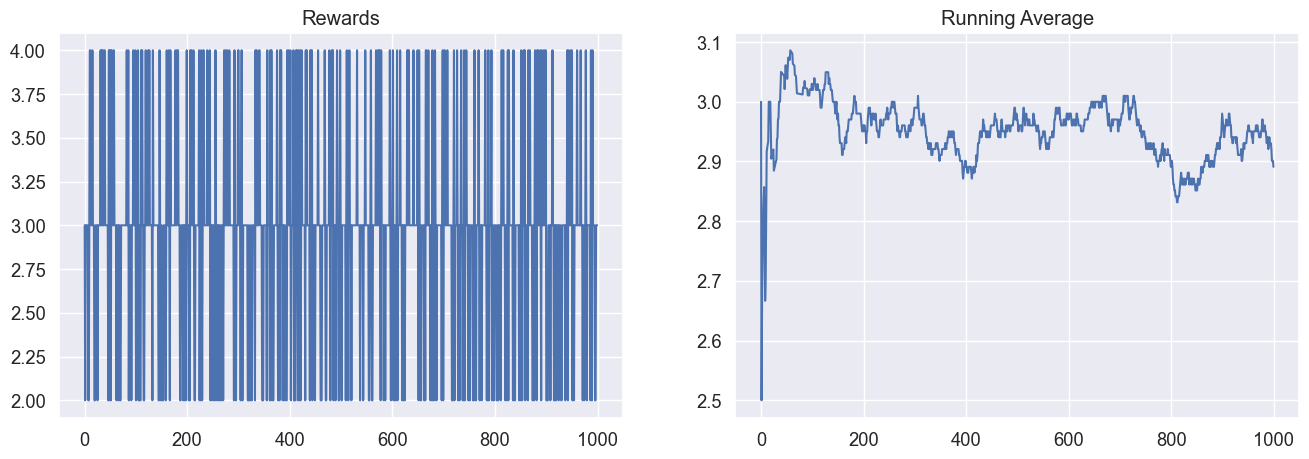

In [115]:
algo_label_short = '100'
algo_label_long = 'Optimal $\lambda=(1,0,0)$'
lc = 1
lb = 0
lf = 0

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso,
)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
# pis = pis[0:25]
agent = FixedPolicyAgent(env, pi=pi)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy $(\lambda^C=1, \lambda^B=1, \lambda^F=0)$

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -2.359
episode: 0, total reward: 2.50, eps: 0.000, avg reward last 100: 2.500
episode: 100, total reward: 2.38, eps: 0.000, avg reward last 100: 2.373
episode: 200, total reward: 2.12, eps: 0.000, avg reward last 100: 2.249
episode: 300, total reward: 4.00, eps: 0.000, avg reward last 100: 2.454
episode: 400, total reward: 3.12, eps: 0.000, avg reward last 100: 2.347
episode: 500, total reward: 2.00, eps: 0.000, avg reward last 100: 2.582
episode: 600, total reward: 1.25, eps: 0.000, avg reward last 100: 2.381
episode: 700, total reward: 1.50, eps: 0.000, avg reward last 100: 2.356
episode: 800, total reward: 2.00, eps: 0.000, avg reward last 100: 2.327
episode: 900, total reward: 2.50, eps: 0.000, avg reward last 100: 2.302

Total steps: 1,000
Avg cumulative reward: 2.377
Avg reward for last 100 episodes: 2.396
0.6 Avg ac

,Y,C,YD,a0,a1
758,1,1,2,0,1
767,1,1,3,0,1
776,1,1,4,0,1
929,1,2,2,0,1
938,1,2,3,0,1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_34708/366943660.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y           
0.0 0.0  1.00000
    1.0  0.97929
    2.0  1.00000
1.0 0.0  1.00000
    1.0  1.00000
    2.0  1.00000


R^C/ep: 	2.352
R^Q/ep: 	1.349
R^F/ep: 	0.839
R^C/ep std: 	0.831
R^Q/ep std: 	0.835
R^F/ep std: 	0.615
R^C/ep p05: 	1.000
R^Q/ep p05: 	0.000
R^F/ep p05: 	0.000
R^C/ep p95: 	3.000
R^Q/ep p95: 	3.000
R^F/ep p95: 	1.750
Y0 AVG: 	0.734
Y1 AVG: 	1.103
Y0 AVG p05: 	0.000
Y1 AVG p05: 	0.000
Y0 AVG p95: 	2.000
Y1 AVG p95: 	2.000
Y0 std: 	0.835
Y1 std: 	0.873
Y0 FINAL: 	0.585
Y1 FINAL: 	1.147
Y0 FINAL std: 	0.766
Y1 FINAL std: 	0.854
Y0 FINAL p05: 	0.000
Y1 FINAL p05: 	0.000
Y0 FINAL p95: 	2.000
Y1 FINAL p95: 	2.000
|Y1-Y0| AVG: 	1.017
|Y1-Y0| std: 	0.801
|Y1-Y0| AVG p05: 	0.000
|Y1-Y0| AVG p95: 	2.000
|Y1-Y0| FINAL: 	0.976
|Y1-Y0| FINAL std: 	0.792
|Y1-Y0| FINAL p05: 	0.000
|Y1-Y0| FINAL p95: 	2.000


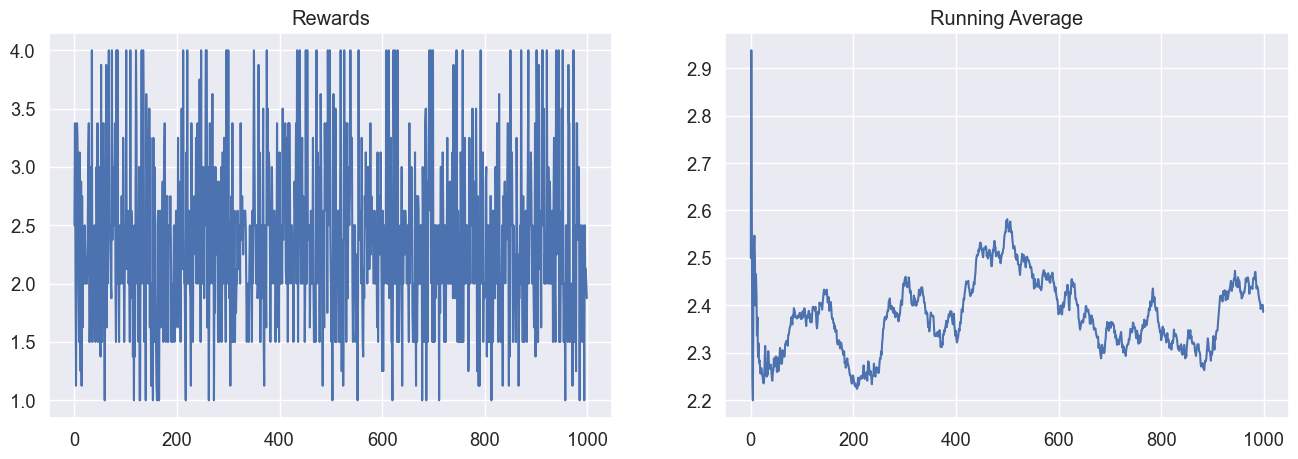

In [117]:
algo_label_short = '110'
algo_label_long = 'Optimal $\lambda=(1,1,0)$'
lc = 1
lb = 1
lf = 0

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]

pis = np.array(pis)
for s in range(pis.shape[1]):
    if np.any(pis[:, s] != pis[0][s]):
        sfeats = env._state_to_feats[s]
        z, y0, y1, c, yd = sfeats
        print(f'{sfeats} has multiple actions.')

del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)

ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=1, \lambda^B=1, \lambda^F=1$)

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -2.027
episode: 0, total reward: 1.50, eps: 0.000, avg reward last 100: 1.500
episode: 100, total reward: 2.33, eps: 0.000, avg reward last 100: 1.924
episode: 200, total reward: 2.83, eps: 0.000, avg reward last 100: 1.957
episode: 300, total reward: 1.83, eps: 0.000, avg reward last 100: 2.026
episode: 400, total reward: 3.33, eps: 0.000, avg reward last 100: 1.931
episode: 500, total reward: 1.67, eps: 0.000, avg reward last 100: 1.927
episode: 600, total reward: 1.67, eps: 0.000, avg reward last 100: 1.805
episode: 700, total reward: 2.08, eps: 0.000, avg reward last 100: 1.937
episode: 800, total reward: 3.33, eps: 0.000, avg reward last 100: 1.988
episode: 900, total reward: 1.33, eps: 0.000, avg reward last 100: 1.926

Total steps: 1,000
Avg cumulative reward: 1.936
Avg reward for last 100 episodes: 1.966
0.6 Avg ac

,Y,C,YD,a0,a1
758,1,1,2,0,1
767,1,1,3,0,1
806,1,1,8,0,1
812,1,1,10,0,1
821,1,1,11,0,1
830,1,1,12,0,1
839,1,1,13,0,1
848,1,1,14,0,1
857,1,1,15,0,1
866,1,1,16,0,1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_34708/366943660.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y            
0.0 0.0  1.000000
    1.0  0.906077
    2.0  1.000000
1.0 0.0  1.000000
    1.0  1.000000
    2.0  1.000000


R^C/ep: 	2.334
R^Q/ep: 	1.292
R^F/ep: 	0.895
R^C/ep std: 	0.844
R^Q/ep std: 	0.849
R^F/ep std: 	0.602
R^C/ep p05: 	1.000
R^Q/ep p05: 	0.000
R^F/ep p05: 	0.000
R^C/ep p95: 	3.000
R^Q/ep p95: 	3.000
R^F/ep p95: 	1.750
Y0 AVG: 	0.716
Y1 AVG: 	1.041
Y0 AVG p05: 	0.000
Y1 AVG p05: 	0.000
Y0 AVG p95: 	2.000
Y1 AVG p95: 	2.000
Y0 std: 	0.814
Y1 std: 	0.873
Y0 FINAL: 	0.560
Y1 FINAL: 	1.091
Y0 FINAL std: 	0.725
Y1 FINAL std: 	0.862
Y0 FINAL p05: 	0.000
Y1 FINAL p05: 	0.000
Y0 FINAL p95: 	2.000
Y1 FINAL p95: 	2.000
|Y1-Y0| AVG: 	0.953
|Y1-Y0| std: 	0.787
|Y1-Y0| AVG p05: 	0.000
|Y1-Y0| AVG p95: 	2.000
|Y1-Y0| FINAL: 	0.887
|Y1-Y0| FINAL std: 	0.770
|Y1-Y0| FINAL p05: 	0.000
|Y1-Y0| FINAL p95: 	2.000


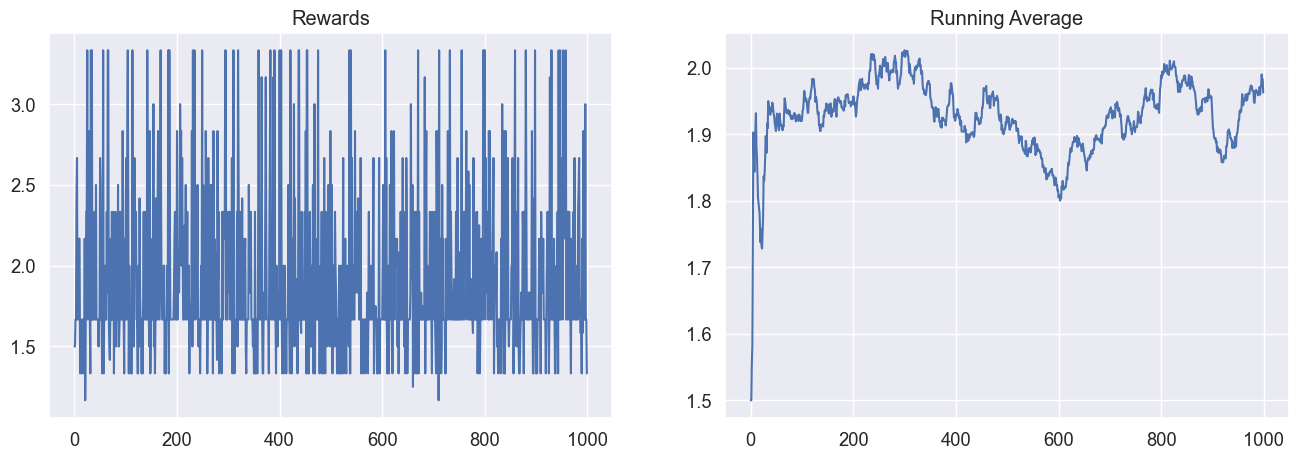

In [118]:
algo_label_short = '111'
algo_label_long = 'Optimal $\lambda=(1,1,1)$'
lc = 1
lb = 1
lf = 1

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)
ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=1, \lambda^B=2, \lambda^F=1$)

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -1.998
episode: 0, total reward: 1.50, eps: 0.000, avg reward last 100: 1.500
episode: 100, total reward: 2.50, eps: 0.000, avg reward last 100: 1.936
episode: 200, total reward: 2.31, eps: 0.000, avg reward last 100: 1.979
episode: 300, total reward: 1.50, eps: 0.000, avg reward last 100: 1.942
episode: 400, total reward: 3.50, eps: 0.000, avg reward last 100: 1.950
episode: 500, total reward: 1.25, eps: 0.000, avg reward last 100: 1.957
episode: 600, total reward: 1.50, eps: 0.000, avg reward last 100: 1.921
episode: 700, total reward: 1.75, eps: 0.000, avg reward last 100: 1.986
episode: 800, total reward: 1.50, eps: 0.000, avg reward last 100: 2.045
episode: 900, total reward: 3.50, eps: 0.000, avg reward last 100: 1.967

Total steps: 1,000
Avg cumulative reward: 1.964
Avg reward for last 100 episodes: 1.976
0.6 Avg ac

,Y,C,YD,a0,a1
758,1,1,2,0,1
767,1,1,3,0,1
776,1,1,4,0,1
785,1,1,5,0,1
794,1,1,6,0,1
803,1,1,7,0,1
804,1,1,8,0,1
808,1,1,9,0,1
812,1,1,10,0,1
821,1,1,11,0,1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_34708/366943660.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y       
0.0 0.0  1.0
    1.0  0.0
    2.0  1.0
1.0 0.0  1.0
    1.0  1.0
    2.0  1.0


R^C/ep: 	1.973
R^Q/ep: 	1.558
R^F/ep: 	0.961
R^C/ep std: 	1.051
R^Q/ep std: 	0.818
R^F/ep std: 	0.493
R^C/ep p05: 	0.000
R^Q/ep p05: 	0.000
R^F/ep p05: 	0.000
R^C/ep p95: 	3.000
R^Q/ep p95: 	3.000
R^F/ep p95: 	1.500
Y0 AVG: 	1.010
Y1 AVG: 	1.078
Y0 AVG p05: 	0.000
Y1 AVG p05: 	0.000
Y0 AVG p95: 	2.000
Y1 AVG p95: 	2.000
Y0 std: 	0.694
Y1 std: 	0.865
Y0 FINAL: 	0.938
Y1 FINAL: 	1.128
Y0 FINAL std: 	0.644
Y1 FINAL std: 	0.857
Y0 FINAL p05: 	0.000
Y1 FINAL p05: 	0.000
Y0 FINAL p95: 	2.000
Y1 FINAL p95: 	2.000
|Y1-Y0| AVG: 	0.855
|Y1-Y0| std: 	0.671
|Y1-Y0| AVG p05: 	0.000
|Y1-Y0| AVG p95: 	2.000
|Y1-Y0| FINAL: 	0.790
|Y1-Y0| FINAL std: 	0.613
|Y1-Y0| FINAL p05: 	0.000
|Y1-Y0| FINAL p95: 	2.000


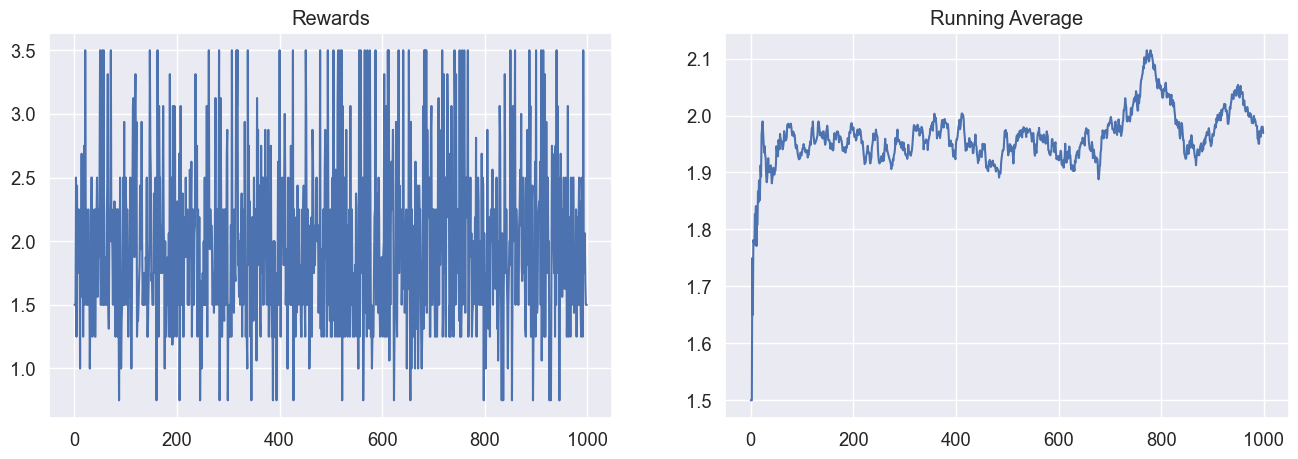

In [119]:
algo_label_short = '121'
algo_label_long = 'Optimal $\lambda=(1,2,1)$'
lc = 1
lb = 2
lf = 1

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)
ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=1, \lambda^B=5, \lambda^F=1$)

In [ ]:
algo_label_short = '151'
algo_label_long = 'Optimal $\lambda=(1,5,1)$'
lc = 1
lb = 5
lf = 1

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)
ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=1, \lambda^B=1, \lambda^F=5$)

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -0.812
episode: 0, total reward: 0.57, eps: 0.000, avg reward last 10,000: 0.571
episode: 10,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 0.782
episode: 20,000, total reward: 0.57, eps: 0.000, avg reward last 10,000: 0.783
episode: 30,000, total reward: 1.39, eps: 0.000, avg reward last 10,000: 0.781
episode: 40,000, total reward: 1.07, eps: 0.000, avg reward last 10,000: 0.784
episode: 50,000, total reward: 1.29, eps: 0.000, avg reward last 10,000: 0.783
episode: 60,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 0.784
episode: 70,000, total reward: 0.57, eps: 0.000, avg reward last 10,000: 0.782
episode: 80,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 0.782
episode: 90,000, total reward: 0.57, eps: 0.000, avg reward last 10,000: 0.785

Total steps: 100,000
Avg cumulative rewar

,Y,C,YD,a0,a1
149,0,1,5,1,0
269,0,2,6,1,0
278,0,2,7,1,0
287,0,2,8,1,0
306,0,2,10,1,0
476,1,1,2,0,1
482,1,1,4,0,1
488,1,1,6,0,1
497,1,1,7,0,1
506,1,1,8,0,1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_26627/1481345851.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y            
0.0 0.0  1.000000
    1.0  0.234462
    2.0  1.000000
1.0 0.0  1.000000
    1.0  0.590330
    2.0  1.000000


R^C/ep: 	0.644
R^Q/ep: 	0.487
R^F/ep: 	0.377
Y0 AVG: 	0.879
Y1 AVG: 	1.086
|Y1-Y0| AVG: 	0.723
Y0 FINAL: 	0.811
Y1 FINAL: 	1.135
|Y1-Y0| FINAL: 	0.667


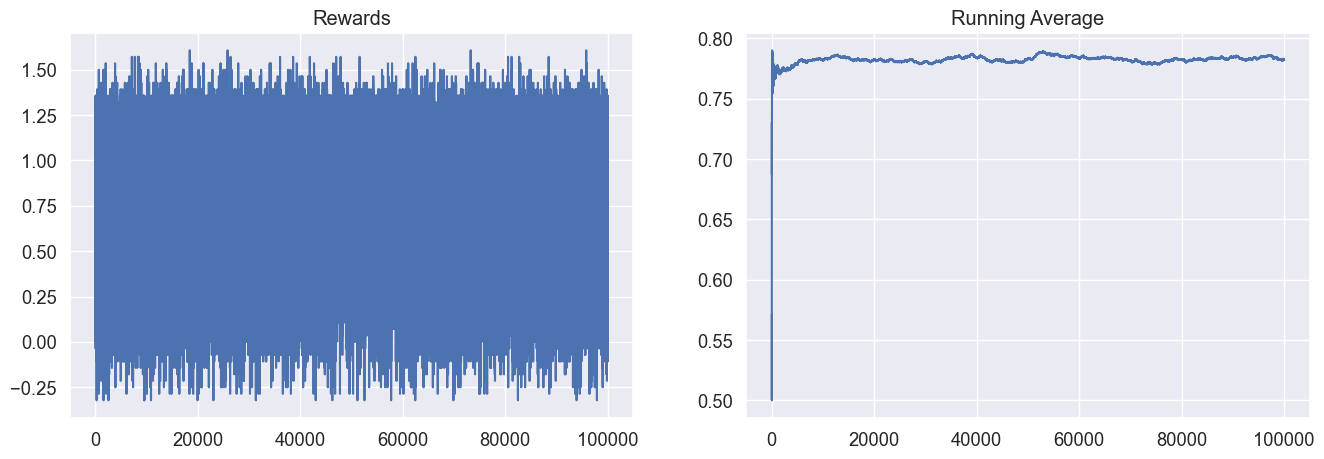

In [124]:
algo_label_short = '115'
algo_label_long = 'Optimal $\lambda=(1,1,5)$'
lc = 1
lb = 1
lf = 5

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)
ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=0, \lambda^B=0, \lambda^F=1$)

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -0.763
episode: 0, total reward: 0.00, eps: 0.000, avg reward last 10,000: 0.000
episode: 10,000, total reward: 0.75, eps: 0.000, avg reward last 10,000: 0.725
episode: 20,000, total reward: 1.00, eps: 0.000, avg reward last 10,000: 0.722
episode: 30,000, total reward: 1.00, eps: 0.000, avg reward last 10,000: 0.719
episode: 40,000, total reward: 1.50, eps: 0.000, avg reward last 10,000: 0.725
episode: 50,000, total reward: 1.00, eps: 0.000, avg reward last 10,000: 0.725
episode: 60,000, total reward: 0.75, eps: 0.000, avg reward last 10,000: 0.727
episode: 70,000, total reward: 1.00, eps: 0.000, avg reward last 10,000: 0.720
episode: 80,000, total reward: 0.75, eps: 0.000, avg reward last 10,000: 0.725
episode: 90,000, total reward: 0.50, eps: 0.000, avg reward last 10,000: 0.725

Total steps: 100,000
Avg cumulative rewar

,Y,C,YD,a0,a1
135,0,1,2,0,1
141,0,1,3,0,1
148,0,1,5,1,0
154,0,1,6,1,0
160,0,1,7,1,0
...,...,...,...,...,...
957,2,2,8,0,1
967,2,2,9,0,1
975,2,2,10,0,1
982,2,2,10,1,0


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_26627/1481345851.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y            
0.0 0.0  0.555776
    1.0  0.213778
    2.0  0.520632
1.0 0.0  0.497771
    1.0  0.254746
    2.0  0.595852


R^C/ep: 	0.123
R^Q/ep: 	0.487
R^F/ep: 	0.400
Y0 AVG: 	0.883
Y1 AVG: 	1.074
|Y1-Y0| AVG: 	0.633
Y0 FINAL: 	0.823
Y1 FINAL: 	1.126
|Y1-Y0| FINAL: 	0.561


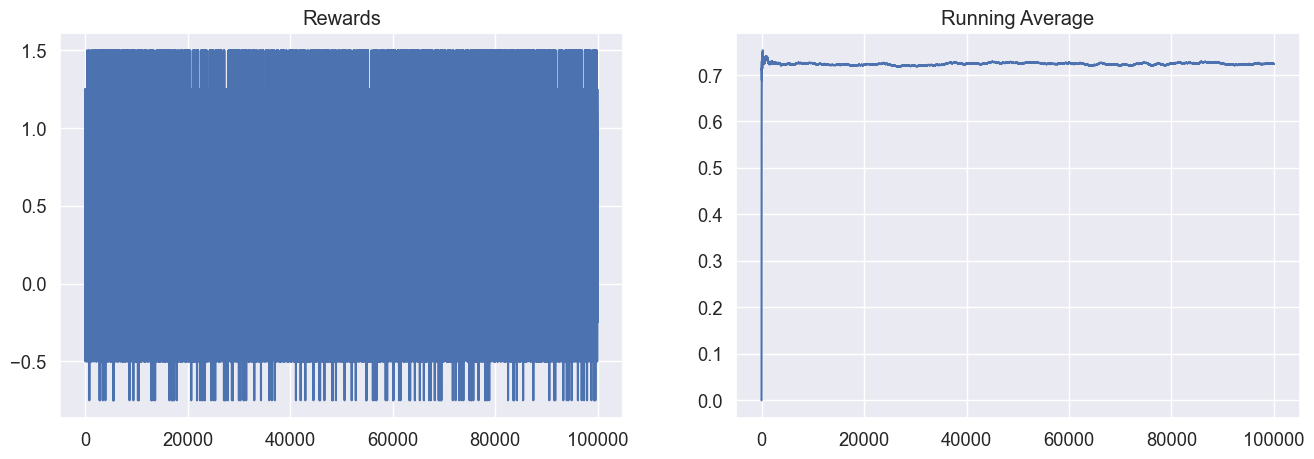

In [125]:
algo_label_short = '001'
algo_label_long = 'Optimal $\lambda=(0,0,1)$'
lc = 0
lb = 0
lf = 1

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)
ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=1, \lambda^B=0, \lambda^F=1$)

In [126]:
# algo_label_short = '101'
# algo_label_long = 'Optimal $\lambda=(1,0,1)$'
# lc = 1
# lb = 0
# lf = 1

# env = LoanMDPv1(state_dims=state_dims,
#                 action_dims=action_dims,
#                 obs_dims=obs_dims,
#                 max_steps_per_episode=max_steps_per_episode,
#                 Osaso_dtype=Osaso_dtype,
#                 obj_weights=[lc, lb, lf],
#                 args=env_args,
#                 T=T,
#                 Osaso=Osaso)

# print('Computing optimal policy ...')
# pis = compute_optimal_policy(env, gamma=gamma)
# pi = pis[0]
# del pis  # Hogging memory
# agent = FixedPolicyAgent(env, pi=pi)
# ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
# print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# # Display policy differences across groups
# display_policy_group_diffs(pi)

# # Compute metrics
# algo_label_long_lookup[algo_label_short] = algo_label_long
# env_hist_df = env.render_env_history()
# # Having a single 'y' columns is useful for some metrics
# env_hist_df['y'] = env_hist_df['y0']
# y1_index = env_hist_df.query('z == 1').index
# env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

# insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
# insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# # Show avg loan rates for each z/y combo
# env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
# display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

# print()
# for k in metrics_by_ep[algo_label_short]:
#     print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=0, \lambda^B=1, \lambda^F=0$)

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -1.093
episode: 0, total reward: 2.00, eps: 0.000, avg reward last 10,000: 2.000
episode: 10,000, total reward: 1.50, eps: 0.000, avg reward last 10,000: 1.078
episode: 20,000, total reward: 0.00, eps: 0.000, avg reward last 10,000: 1.068
episode: 30,000, total reward: 1.00, eps: 0.000, avg reward last 10,000: 1.076
episode: 40,000, total reward: 1.50, eps: 0.000, avg reward last 10,000: 1.078
episode: 50,000, total reward: 0.50, eps: 0.000, avg reward last 10,000: 1.077
episode: 60,000, total reward: 0.50, eps: 0.000, avg reward last 10,000: 1.082
episode: 70,000, total reward: 0.75, eps: 0.000, avg reward last 10,000: 1.083
episode: 80,000, total reward: 0.50, eps: 0.000, avg reward last 10,000: 1.072
episode: 90,000, total reward: 1.50, eps: 0.000, avg reward last 10,000: 1.072

Total steps: 100,000
Avg cumulative rewar

,Y,C,YD,a0,a1
470,1,1,2,0,1
479,1,1,3,0,1
480,1,1,4,0,1
484,1,1,5,0,1
488,1,1,6,0,1
497,1,1,7,0,1
506,1,1,8,0,1
515,1,1,9,0,1
525,1,1,10,0,1
569,1,2,2,0,1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_26627/1481345851.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y            
0.0 0.0  1.000000
    1.0  0.000000
    2.0  0.000000
1.0 0.0  0.879154
    1.0  0.971621
    2.0  0.000000


R^C/ep: 	0.073
R^Q/ep: 	0.542
R^F/ep: 	0.339
Y0 AVG: 	0.985
Y1 AVG: 	1.168
|Y1-Y0| AVG: 	0.857
Y0 FINAL: 	0.925
Y1 FINAL: 	1.243
|Y1-Y0| FINAL: 	0.797


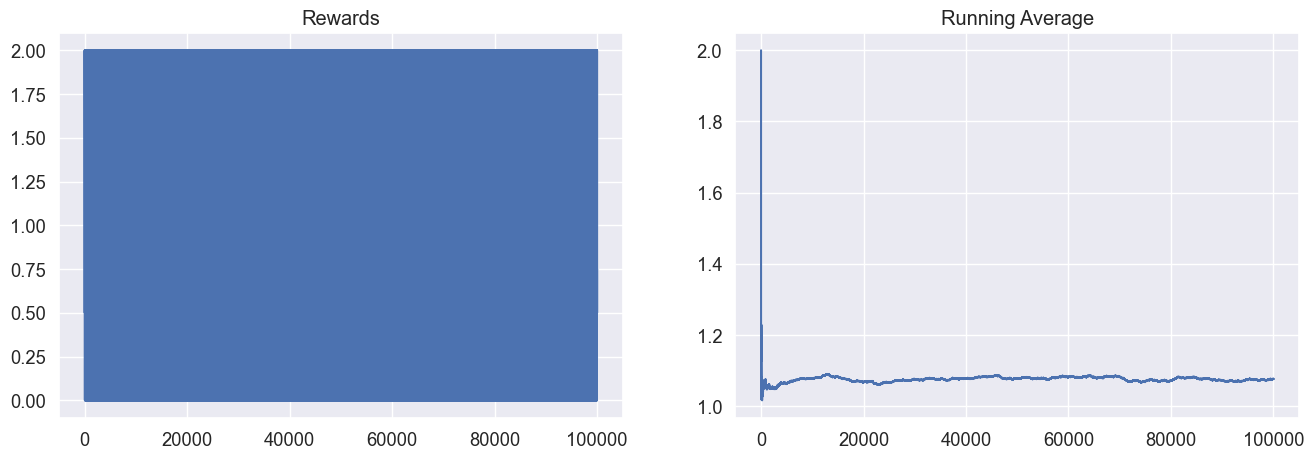

In [127]:
algo_label_short = '010'
algo_label_long = 'Optimal $\lambda=(0,1,0)$'
lc = 0
lb = 1
lf = 0

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)
ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Optimal Policy ($\lambda^C=5, \lambda^B=1, \lambda^F=1$)

INFO:root:DiscreteMDP - Version 0.0.1


Constructing reward matrix...
Check all observation probabilities sum to 1...
Checking all transition probabilities sum to 1...
Computing optimal policy ...
res.fun: -1.167
episode: 0, total reward: 1.57, eps: 0.000, avg reward last 10,000: 1.571
episode: 10,000, total reward: 1.64, eps: 0.000, avg reward last 10,000: 1.161
episode: 20,000, total reward: 1.71, eps: 0.000, avg reward last 10,000: 1.155
episode: 30,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 1.152
episode: 40,000, total reward: 1.71, eps: 0.000, avg reward last 10,000: 1.158
episode: 50,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 1.163
episode: 60,000, total reward: 1.71, eps: 0.000, avg reward last 10,000: 1.157
episode: 70,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 1.157
episode: 80,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 1.152
episode: 90,000, total reward: 0.86, eps: 0.000, avg reward last 10,000: 1.154

Total steps: 100,000
Avg cumulative rewar

,Y,C,YD,a0,a1


/var/folders/xl/lb4g1y1n0td93t_q2wsddc3h0000gn/T/ipykernel_26627/1481345851.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, ep_df])


a
z   y       
0.0 0.0  1.0
    1.0  1.0
    2.0  1.0
1.0 0.0  1.0
    1.0  1.0
    2.0  1.0


R^C/ep: 	0.764
R^Q/ep: 	0.452
R^F/ep: 	0.322
Y0 AVG: 	0.741
Y1 AVG: 	1.108
|Y1-Y0| AVG: 	0.919
Y0 FINAL: 	0.652
Y1 FINAL: 	1.157
|Y1-Y0| FINAL: 	0.886


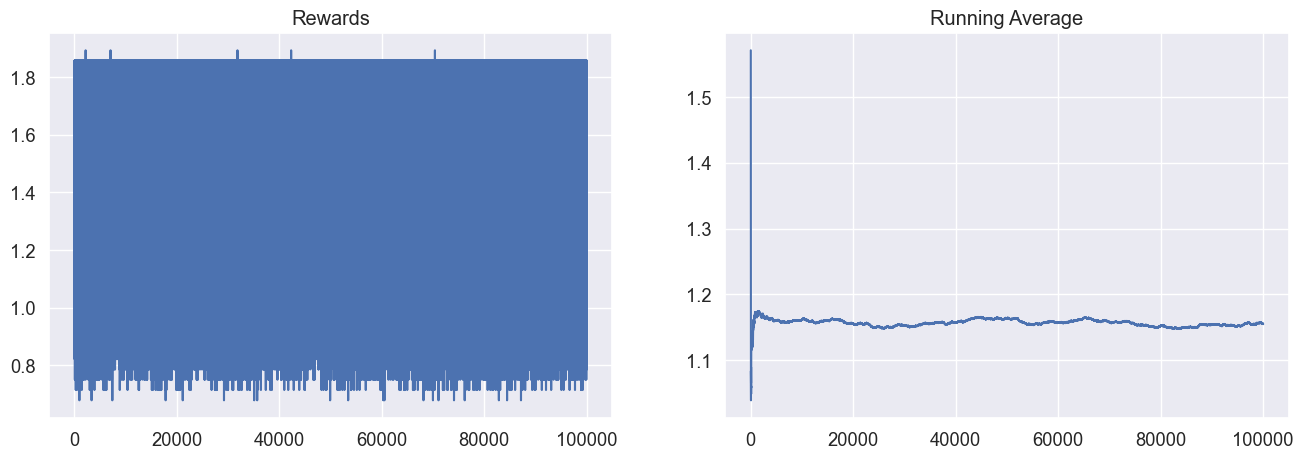

In [129]:
algo_label_short = '511'
algo_label_long = 'Optimal $\lambda=(5,1,1)$'
lc = 5
lb = 1
lf = 1

env = LoanMDPv1(state_dims=state_dims,
                action_dims=action_dims,
                obs_dims=obs_dims,
                max_steps_per_episode=max_steps_per_episode,
                Osaso_dtype=Osaso_dtype,
                obj_weights=[lc, lb, lf],
                args=env_args,
                T=T,
                Osaso=Osaso)

print('Computing optimal policy ...')
pis = compute_optimal_policy(env, gamma=gamma)
pi = pis[0]
del pis  # Hogging memory
agent = FixedPolicyAgent(env, pi=pi)
ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# Display policy differences across groups
display_policy_group_diffs(pi)

# Compute metrics
algo_label_long_lookup[algo_label_short] = algo_label_long
env_hist_df = env.render_env_history()
# Having a single 'y' columns is useful for some metrics
env_hist_df['y'] = env_hist_df['y0']
y1_index = env_hist_df.query('z == 1').index
env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# Show avg loan rates for each z/y combo
env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

print()
for k in metrics_by_ep[algo_label_short]:
    print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Compare

,Algo,R^C/ep,R^Q/ep,R^F/ep,R^C/ep std,R^Q/ep std,R^F/ep std,R^C/ep p05,R^Q/ep p05,R^F/ep p05,R^C/ep p95,R^Q/ep p95,R^F/ep p95,Y0 AVG,Y1 AVG,Y0 AVG p05,Y1 AVG p05,Y0 AVG p95,Y1 AVG p95,Y0 std,Y1 std,Y0 FINAL,Y1 FINAL,Y0 FINAL std,Y1 FINAL std,Y0 FINAL p05,Y1 FINAL p05,Y0 FINAL p95,Y1 FINAL p95,|Y1-Y0| AVG,|Y1-Y0| std,|Y1-Y0| AVG p05,|Y1-Y0| AVG p95,|Y1-Y0| FINAL,|Y1-Y0| FINAL std,|Y1-Y0| FINAL p05,|Y1-Y0| FINAL p95
0,Man,1.209,1.182,0.878,1.088,0.878,0.655,0.0,0.0,0.0,3.0,3.0,1.512,0.632,1.006,0.0,0.0,2.0,2.0,0.838,0.898,0.469,1.033,0.757,0.894,0.0,0.0,2.0,2.0,0.973,0.843,0.0,2.0,0.892,0.852,0.0,2.0
1,100,2.39,1.342,0.896,0.798,0.87,0.597,1.0,0.0,0.0,3.0,3.0,1.75,0.765,1.062,0.0,0.0,2.0,2.0,0.83,0.872,0.616,1.096,0.765,0.862,0.0,0.0,2.0,2.0,0.938,0.789,0.0,2.0,0.906,0.77,0.0,2.0
2,110,2.352,1.348,0.839,0.831,0.835,0.615,1.0,0.0,0.0,3.0,3.0,1.75,0.734,1.103,0.0,0.0,2.0,2.0,0.835,0.873,0.585,1.147,0.766,0.854,0.0,0.0,2.0,2.0,1.017,0.801,0.0,2.0,0.976,0.792,0.0,2.0
3,111,2.334,1.292,0.895,0.844,0.849,0.602,1.0,0.0,0.0,3.0,3.0,1.75,0.716,1.041,0.0,0.0,2.0,2.0,0.814,0.873,0.56,1.091,0.725,0.862,0.0,0.0,2.0,2.0,0.953,0.787,0.0,2.0,0.887,0.77,0.0,2.0
4,121,1.973,1.558,0.961,1.051,0.818,0.493,0.0,0.0,0.0,3.0,3.0,1.5,1.01,1.078,0.0,0.0,2.0,2.0,0.694,0.865,0.938,1.128,0.644,0.857,0.0,0.0,2.0,2.0,0.855,0.671,0.0,2.0,0.79,0.613,0.0,2.0




Rounded to 2 decimal places:


,Algo,R^C/ep,R^Q/ep,R^F/ep,R^C/ep std,R^Q/ep std,R^F/ep std,R^C/ep p05,R^Q/ep p05,R^F/ep p05,...,Y0 FINAL p95,Y1 FINAL p95,|Y1-Y0| AVG,|Y1-Y0| std,|Y1-Y0| AVG p05,|Y1-Y0| AVG p95,|Y1-Y0| FINAL,|Y1-Y0| FINAL std,|Y1-Y0| FINAL p05,|Y1-Y0| FINAL p95
0,Man,1.21,1.18,0.88,1.09,0.88,0.66,0.0,0.0,0.0,...,2.0,2.0,0.97,0.84,0.0,2.0,0.89,0.85,0.0,2.0
1,100,2.39,1.34,0.9,0.8,0.87,0.6,1.0,0.0,0.0,...,2.0,2.0,0.94,0.79,0.0,2.0,0.91,0.77,0.0,2.0
2,110,2.35,1.35,0.84,0.83,0.84,0.62,1.0,0.0,0.0,...,2.0,2.0,1.02,0.8,0.0,2.0,0.98,0.79,0.0,2.0
3,111,2.33,1.29,0.9,0.84,0.85,0.6,1.0,0.0,0.0,...,2.0,2.0,0.95,0.79,0.0,2.0,0.89,0.77,0.0,2.0
4,121,1.97,1.56,0.96,1.05,0.82,0.49,0.0,0.0,0.0,...,2.0,2.0,0.86,0.67,0.0,2.0,0.79,0.61,0.0,2.0


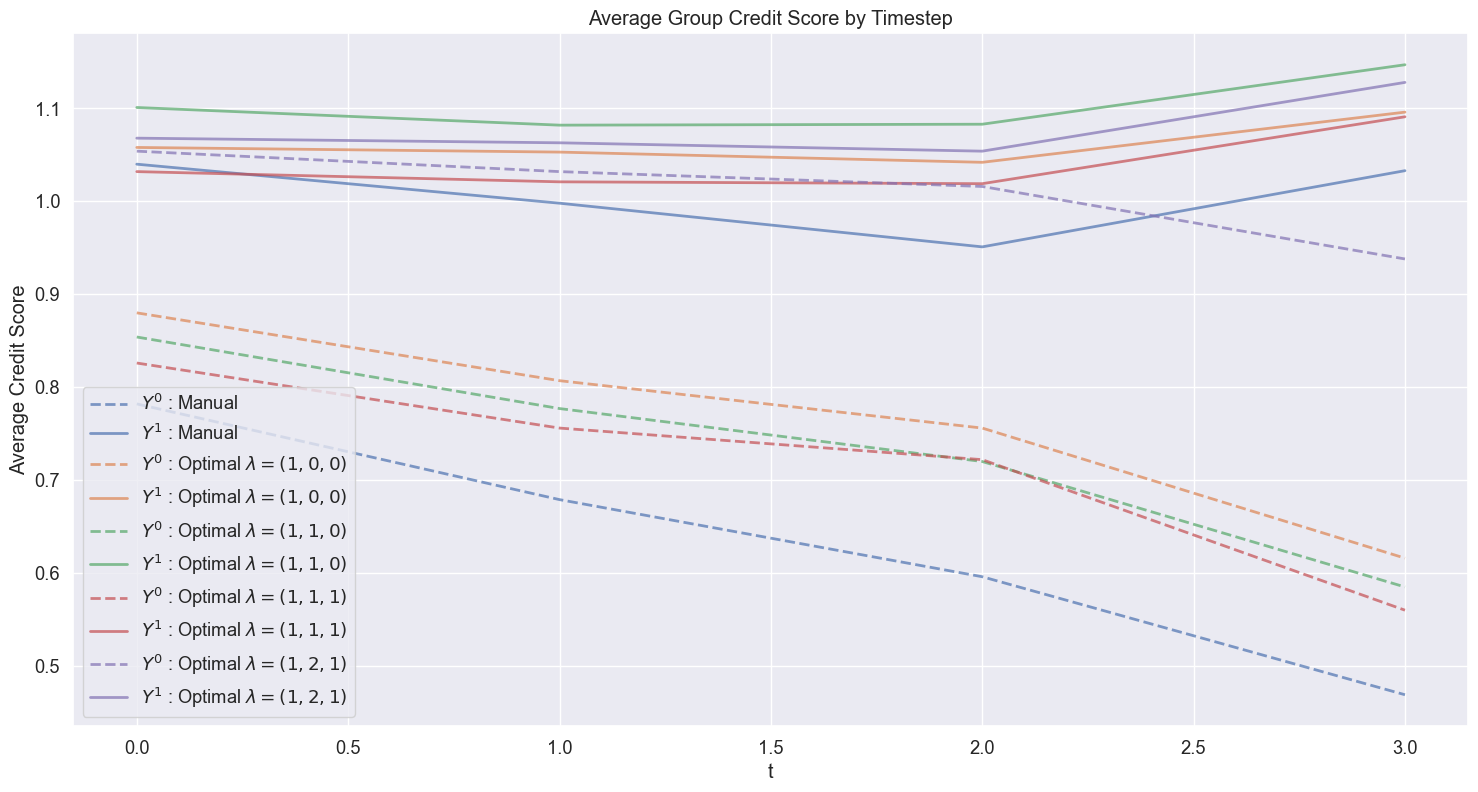

In [120]:
import pandas as pd


# Plot avg credit scores over time
fig, ax = plt.subplots(1, 1, figsize=(18, 9))

ls_patterns = ['--', '-']

metrics_by_ep_to_show = []
for (to_show, _, label, _) in metrics_by_ep_catalog:
    if to_show:
        metrics_by_ep_to_show.append(label)
            
results_table = []

    
for i, algo_label_short in enumerate(algo_label_long_lookup):
    algo_label_long = algo_label_long_lookup[algo_label_short]
    _metrics_by_t = metrics_by_t[algo_label_short]
    
    ax.plot(
        np.arange(len(_metrics_by_t['Y0'])),
        _metrics_by_t['Y0'],
        label=f'$Y^0$ : {algo_label_long}',
        c=sns.color_palette()[i],
        ls=ls_patterns[0],
        lw=2,
        alpha=.7)
    ax.plot(
        np.arange(len(_metrics_by_t['Y1'])),
        _metrics_by_t['Y1'],
        label=f'$Y^1$ : {algo_label_long}',
        c=sns.color_palette()[i],
        ls=ls_patterns[1],
        lw=2,
        alpha=.7)
    
    _metrics_by_ep = metrics_by_ep[algo_label_short]
    
    results_table.append(np.array([algo_label_short] + [np.round(_metrics_by_ep[l], 3) for l in metrics_by_ep_to_show]))


# Show results as table with max/min values highlighted
results_table = np.array(results_table)
results_table = pd.DataFrame(results_table, columns=['Algo'] + [k for k in _metrics_by_ep])

pos_metric_list = []
neg_metric_list = []

for k in pos_metrics:
    if k in metrics_by_ep_to_show:
        if pos_metrics[k]:
            pos_metric_list.append(k)
        else:
            neg_metric_list.append(k)

display(results_table.style
        .highlight_max(subset=pos_metric_list, color='lightsteelblue')
        .highlight_min(subset=pos_metric_list, color='mistyrose')
        .highlight_min(subset=neg_metric_list, color='lightsteelblue')
        .highlight_max(subset=neg_metric_list, color='mistyrose')
       )

print('\n\nRounded to 2 decimal places:')
results_table.iloc[:,1:] = results_table.iloc[:,1:].astype(float).round(2)  # Round to 2 decimal places
display(results_table)

ax.set_xlabel('t')
ax.set_ylabel('Average Credit Score')
ax.set_title('Average Group Credit Score by Timestep')
ax.legend()
plt.show()


def persist_results(experiment_name, results_table):
    prefix = './../../data/experiment_output/repeat_loan/results'
    filename = f"{prefix}/{experiment_name}.csv"
    results_table.to_csv(filename, index=None)
    return None

persist_results(EXPERIMENT_NAME, results_table)

,Algo,R^C/ep,R^Q/ep,R^F/ep,Y0 AVG,Y1 AVG,|Y1-Y0| AVG,Y0 FINAL,Y1 FINAL,|Y1-Y0| FINAL
0,Man,0.425,0.424,0.318,0.685,1.065,0.924,0.578,1.118,0.867
1,100,0.759,0.457,0.32,0.75,1.116,0.917,0.661,1.165,0.884
2,110,0.767,0.452,0.327,0.747,1.1,0.91,0.658,1.149,0.874
3,111,0.756,0.456,0.323,0.748,1.113,0.915,0.657,1.169,0.883
4,121,0.698,0.495,0.355,0.877,1.109,0.792,0.817,1.162,0.742
5,151,0.664,0.51,0.34,0.947,1.106,0.848,0.882,1.158,0.795
6,115,0.637,0.491,0.377,0.876,1.102,0.719,0.811,1.153,0.669
7,001,0.117,0.489,0.401,0.884,1.074,0.634,0.826,1.128,0.563
8,101,0.761,0.46,0.317,0.754,1.123,0.921,0.669,1.173,0.89




Rounded to 2 decimal places:


,Algo,R^C/ep,R^Q/ep,R^F/ep,Y0 AVG,Y1 AVG,|Y1-Y0| AVG,Y0 FINAL,Y1 FINAL,|Y1-Y0| FINAL
0,Man,0.42,0.42,0.32,0.68,1.06,0.92,0.58,1.12,0.87
1,100,0.76,0.46,0.32,0.75,1.12,0.92,0.66,1.16,0.88
2,110,0.77,0.45,0.33,0.75,1.1,0.91,0.66,1.15,0.87
3,111,0.76,0.46,0.32,0.75,1.11,0.92,0.66,1.17,0.88
4,121,0.7,0.5,0.36,0.88,1.11,0.79,0.82,1.16,0.74
5,151,0.66,0.51,0.34,0.95,1.11,0.85,0.88,1.16,0.8
6,115,0.64,0.49,0.38,0.88,1.1,0.72,0.81,1.15,0.67
7,001,0.12,0.49,0.4,0.88,1.07,0.63,0.83,1.13,0.56
8,101,0.76,0.46,0.32,0.75,1.12,0.92,0.67,1.17,0.89


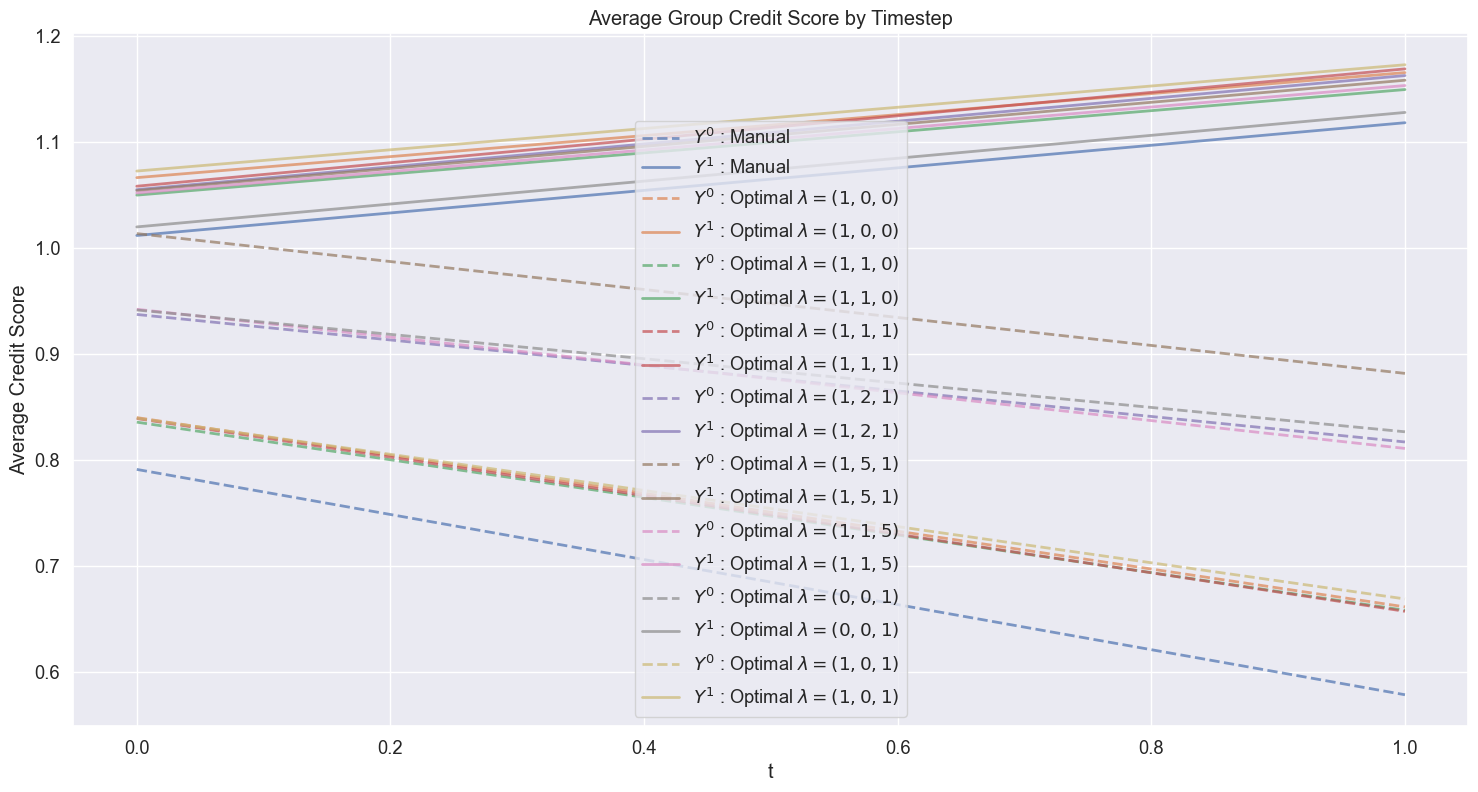

#### STOP

##### Random Policy

In [ ]:
# algo_label_short = 'Rnd'
# algo_label_long = 'Random'
# lc = 1
# lb = 0
# lf = 0

# env = LoanMDPv1(state_dims=state_dims,
#                 action_dims=action_dims,
#                 obs_dims=obs_dims,
#                 max_steps_per_episode=max_steps_per_episode,
#                 obj_weights=[lc, lb, lf],
#                 args=env_args,
# )

# agent = RandomAgent(env)

# ax0, ax1 = play_n_episodes(env, agent, n=n_episodes, use_eps=False)
# print(f'{np.mean(env.action_episode_memory[1])} Avg action of first episode')

# # Compute metrics
# algo_label_long_lookup[algo_label_short] = algo_label_long
# env_hist_df = env.render_env_history()
# # Having a single 'y' columns is useful for some metrics
# env_hist_df['y'] = env_hist_df['y0']
# y1_index = env_hist_df.query('z == 1').index
# env_hist_df.loc[y1_index, 'y'] = env_hist_df['y1']

# insert_metric_computations(metrics_by_t, pos_metrics, metrics_by_t_catalog, env_hist_df, algo_label_short)
# insert_metric_computations(metrics_by_ep, pos_metrics, metrics_by_ep_catalog, env_hist_df, algo_label_short)

# # Show avg loan rates for each z/y combo
# env_hist_df['a'] = env_hist_df['a'].astype(float)  # Not sure why this is needed.
# display(env_hist_df.query('c > 0').groupby(['z', 'y'])[['a']].mean())

# print()
# for k in metrics_by_ep[algo_label_short]:
#     print(f'{k}: \t{metrics_by_ep[algo_label_short][k]:,.3f}')

##### Desired Results

Algo | Profit | Y0| Y1 | TPR Z=0 | TPR Z=1
---   | --- | --- | --- | --- | ---
Wen21 | .80  | .7  | .85 | 1 | 1.0
$\pi^*_{100}$ | **.90** | .8 | .85 | 0 | 1.0
$\pi^*_{110}$ | .80 | **.9** | **.85** | .5 | 1.0

# Scratch

In [148]:
class Scratch:
    
    def __init__(self, state_comp_dims):
        self.state_comp_dims = state_comp_dims
        self.n_states = np.prod(self.state_comp_dims)
        
    def _encode_state_idx_map(self):
        # construction variables
        features_by_state_index = np.zeros((self.n_states, len(self.state_comp_dims)), dtype=int)
        state_index_by_features = {}
        # temp variables
        state_comp_cur_idxs = np.zeros_like(self.state_comp_dims)
        furth_right_non_max_idx = len(self.state_comp_dims) - 1
        state_idx = 0
        done = False
        
        # Iterate over every permutation of state features
        while not done:
            # Set features_by_state_index and state_index_by_features 
            #   with current vals of temp vars.
            #   state_comp_cur_idxs e.g. [3, 0, 2] if 3 state components.
            #   State component 0 is at index 3, ...
            for state_comp_idx, state_comp_val in enumerate(state_comp_cur_idxs):
                features_by_state_index[state_idx][state_comp_idx] = state_comp_val
                state_index_by_features[''.join(state_comp_cur_idxs.astype(str))] = state_idx
                    
            # Increment/decrement temp vars
            
            # Increment state_idx since it's been used (above).
            state_idx += 1
            
            # Starting from the right, find the first index val that's < it's respective
            # dim size, increment it by 1, then reset all index vals to the right
            # of it to zero.
            done = True
            for idx in range(len(state_comp_cur_idxs)-1, -1, -1):
                if state_comp_cur_idxs[idx] < self.state_comp_dims[idx]-1:
                    state_comp_cur_idxs[idx] += 1
                    for comp_idx in range(idx+1, len(self.state_comp_dims)):
                        state_comp_cur_idxs[comp_idx] = 0
                    done = False
                    break

        self._features_by_state_index = features_by_state_index
        self._state_index_by_features = state_index_by_features
        
        return None

In [149]:
s = Scratch((3, 3, 3))
s._encode_state_idx_map()

display(s._features_by_state_index)
display(s._state_index_by_features)

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 1, 0],
       [2, 1, 1],
       [2, 1, 2],
       [2, 2, 0],
       [2, 2, 1],
       [2, 2, 2]])

{'000': 0,
 '001': 1,
 '002': 2,
 '010': 3,
 '011': 4,
 '012': 5,
 '020': 6,
 '021': 7,
 '022': 8,
 '100': 9,
 '101': 10,
 '102': 11,
 '110': 12,
 '111': 13,
 '112': 14,
 '120': 15,
 '121': 16,
 '122': 17,
 '200': 18,
 '201': 19,
 '202': 20,
 '210': 21,
 '211': 22,
 '212': 23,
 '220': 24,
 '221': 25,
 '222': 26}

In [ ]:
#                 # Compute the state index
#                 for comp_idx in range(len(self.state_comp_dims)):
#                     comp_offset = 1
#                     for right_comp_idx in range(comp_idx, len(self.state_comp_dims)):
#                         comp_offset *= self.state_comp_dims[right_comp_idx]
#                     comp_offset *= ?  # Fix this
#                 state_comp_idx += comp_offset  # Check this
#                 # LEFT OFF HERE  